# Resnet18 CIFAR-10

Quantize train resnet18 without PACT

In [1]:
NOQUANT_TRAIN = False
n_epochs = 200
batches = 2048

In [2]:
import argparse
import os
import shutil
import time
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import time
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau


DATA_DIR = "train"
print_freq = 50

# vit imsize
imsize = 32

In [3]:
# prepare labels
train_df = pd.read_csv("trainLabels.csv")
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])

# 5-fold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_df["fold"] = -1
for i, (train_index, test_index) in enumerate(skf.split(train_df.id, train_df.label_enc)):
    train_df.loc[test_index, 'fold'] = i
train_df.head()

,id,label,label_enc,fold
0,1,frog,6,1
1,2,truck,9,1
2,3,truck,9,2
3,4,deer,4,1
4,5,automobile,1,2


In [4]:
class cifarDataset(Dataset):
    def __init__(self,
                 df,
                 rand=False,
                 transform=None,
                 test=False
                ):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform
        self.test = test

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.id
        
        images = cv2.imread(os.path.join(DATA_DIR, str(img_id)+".png"))
        
        # Load labels
        label = row.label_enc
        
        # aug
        if self.transform is not None:
            images = self.transform(image=images)['image']
              
        #images = images.astype(np.float32)
        #images /= 255
        images = images.transpose(2, 0, 1)
        
        label = label.astype(np.float32)
        #label2 = label2.astype(np.float32)
        return torch.tensor(images), torch.tensor(label),

In [5]:
import albumentations as A
import albumentations

transforms_train = albumentations.Compose([
    albumentations.ShiftScaleRotate(scale_limit=0.3, rotate_limit=180,p=0.5),
    A.Cutout(num_holes=12, max_h_size=4, max_w_size=4, fill_value=0, p=0.5),
    albumentations.Rotate(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),   
    albumentations.Resize(imsize, imsize, p=1.0), 
    albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),
])

transforms_val = albumentations.Compose([albumentations.Resize(imsize, imsize, p=1.0),
                                         albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),])

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

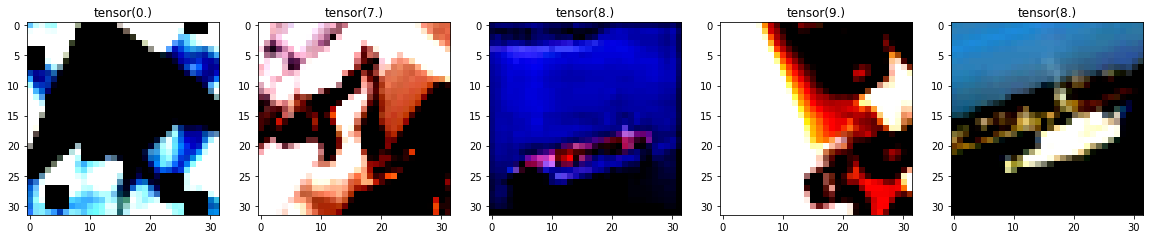

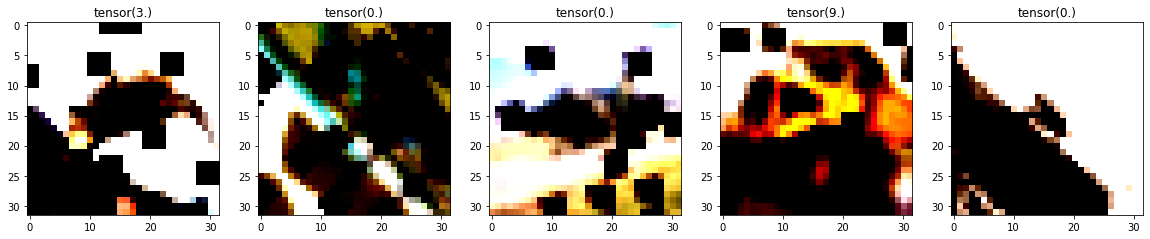

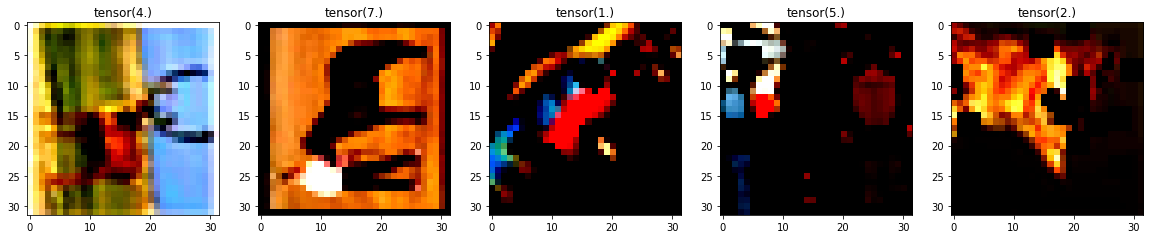

In [6]:
dataset_show = cifarDataset(train_df, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = img.flip(0) #BGR2RGB
        axarr[p].imshow(img.transpose(0,1).transpose(1,2))
        axarr[p].set_title(str(label))
plt.show()

In [7]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    lambda_alpha = 0.002
    for i, (input, target) in enumerate(tqdm(train_loader)):

        # measure data loading time
        data_time.update(time.time() - end)
        target2 = target

        target = target.long().cuda()
        target2 = target2.long().cuda()
        input_var = input.cuda()
        target_var = target

        if not mixup:
          alpha = 0
        else:
          alpha = 1
        

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # L2 regularization
        l2_alpha = 0.0
        for name, param in model.named_parameters():
            if "alpha" in name:
                l2_alpha += torch.pow(param, 2)
        loss += lambda_alpha * l2_alpha

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
    return losses.avg

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.long().cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))
    for name, param in model.named_parameters():
        if "alpha" in name:
            print(name, param.item())
    return top1.avg, losses.avg

def save_checkpoint(state, filename='checkpoint.pth'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [8]:
train_dataset = cifarDataset(train_df[train_df.fold!=0], transform=transforms_train)
val_dataset = cifarDataset(train_df[train_df.fold==0], transform=transforms_val, test=True)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batches, shuffle=True,
        num_workers=8, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batches, shuffle=False,
    num_workers=8, pin_memory=True)

In [9]:
from network.resnet import resnet20
net = resnet20(abits=8, wbits=8, pact=False, shallow=False)

abit/wbit: 8 8


In [10]:
net.forward(torch.randn(1,3,32,32))

tensor([[-0.6263, -0.5618,  0.2861,  0.0461,  0.5797, -0.1555,  0.1262, -0.0095,
         -0.3979, -0.2527]], grad_fn=<AddmmBackward>)

# Train with quantization

In [ ]:
from timm.scheduler import CosineLRScheduler

for shallow in [True, False]:
    for pact in [False, True]:
        for k in range(2,9):
            net = resnet20(k,k,pact,shallow)

            model = net.cuda()
            mixup = False

            # Track experiment with wandb
            import wandb
            watermark = "resnet18_uniformquantize_k{}".format(k)
            if pact: watermark+="_pact"
            if shallow: 
                watermark+="_shallow"
            else:
                watermark+="_deep"
                
            # mess with wandb
            wandb.init(project="quantize_resnet2", name=watermark)

            # define loss function (criterion) and pptimizer
            criterion = nn.CrossEntropyLoss().cuda()

            # optimizer for pact
            optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,
                                        momentum=0.9,
                                        weight_decay=0.0002)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

            scheduler = CosineLRScheduler(optimizer, t_initial=n_epochs, lr_min=1e-6, 
                                  warmup_t=3, warmup_lr_init=1e-6, warmup_prefix=True)

            best_prec1 = 0
            os.makedirs("models", exist_ok=True)

            for epoch in range(n_epochs):
                scheduler.step(epoch)
                # train for one epoch
                print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
                tloss = train(train_loader, model, criterion, optimizer, epoch)         

                # evaluate on validation set
                prec1, valloss = validate(val_loader, model, criterion)

                # wandb
                wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

                # remember best prec@1 and save checkpoint
                is_best = prec1 > best_prec1
                best_prec1 = max(prec1, best_prec1)

                print("Best prec1 : ", best_prec1)
                if is_best:
                    torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))

abit/wbit: 2 2


wandb: Currently logged in as: arutema47. Use `wandb login --relogin` to force relogin


current lr 1.00000e-06


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [0][0/20]	Time 3.080 (3.080)	Data 2.128 (2.128)	Loss 2.5016 (2.5016)	Prec@1 9.814 (9.814)
Test: [0/5]	Time 0.871 (0.871)	Loss 2.3628 (2.3628)	Prec@1 9.473 (9.473)
 * Prec@1 9.830
Best prec1 :  9.830000091552735
current lr 3.34000e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [1][0/20]	Time 2.572 (2.572)	Data 2.213 (2.213)	Loss 2.4899 (2.4899)	Prec@1 10.791 (10.791)
Test: [0/5]	Time 0.896 (0.896)	Loss 2.2588 (2.2588)	Prec@1 17.578 (17.578)
 * Prec@1 18.130
Best prec1 :  18.12999994506836
current lr 6.67000e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [2][0/20]	Time 2.765 (2.765)	Data 2.403 (2.403)	Loss 2.1332 (2.1332)	Prec@1 19.385 (19.385)
Test: [0/5]	Time 0.934 (0.934)	Loss 2.0665 (2.0665)	Prec@1 23.291 (23.291)
 * Prec@1 24.710
Best prec1 :  24.710000030517577
current lr 1.00000e-03


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [3][0/20]	Time 2.281 (2.281)	Data 1.912 (1.912)	Loss 1.9722 (1.9722)	Prec@1 27.246 (27.246)
Test: [0/5]	Time 0.908 (0.908)	Loss 1.9264 (1.9264)	Prec@1 26.709 (26.709)
 * Prec@1 27.340
Best prec1 :  27.339999984741212
current lr 9.99938e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [4][0/20]	Time 2.182 (2.182)	Data 1.820 (1.820)	Loss 1.9450 (1.9450)	Prec@1 28.271 (28.271)
Test: [0/5]	Time 0.895 (0.895)	Loss 2.0504 (2.0504)	Prec@1 27.637 (27.637)
 * Prec@1 26.710
Best prec1 :  27.339999984741212
current lr 9.99754e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [5][0/20]	Time 1.939 (1.939)	Data 1.569 (1.569)	Loss 1.8549 (1.8549)	Prec@1 31.299 (31.299)
Test: [0/5]	Time 0.888 (0.888)	Loss 1.9819 (1.9819)	Prec@1 27.246 (27.246)
 * Prec@1 28.180
Best prec1 :  28.180000225830078
current lr 9.99445e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [6][0/20]	Time 1.969 (1.969)	Data 1.606 (1.606)	Loss 1.8700 (1.8700)	Prec@1 30.322 (30.322)
Test: [0/5]	Time 0.894 (0.894)	Loss 1.8914 (1.8914)	Prec@1 31.152 (31.152)
 * Prec@1 30.900
Best prec1 :  30.90000010986328
current lr 9.99014e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [7][0/20]	Time 2.398 (2.398)	Data 2.033 (2.033)	Loss 1.7905 (1.7905)	Prec@1 35.547 (35.547)
Test: [0/5]	Time 0.888 (0.888)	Loss 1.7764 (1.7764)	Prec@1 35.205 (35.205)
 * Prec@1 35.140
Best prec1 :  35.13999982910156
current lr 9.98460e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [8][0/20]	Time 1.907 (1.907)	Data 1.538 (1.538)	Loss 1.7871 (1.7871)	Prec@1 34.814 (34.814)
Test: [0/5]	Time 0.946 (0.946)	Loss 1.8172 (1.8172)	Prec@1 34.473 (34.473)
 * Prec@1 34.120
Best prec1 :  35.13999982910156
current lr 9.97783e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [9][0/20]	Time 2.425 (2.425)	Data 2.060 (2.060)	Loss 1.7333 (1.7333)	Prec@1 38.232 (38.232)
Test: [0/5]	Time 0.937 (0.937)	Loss 1.8170 (1.8170)	Prec@1 33.740 (33.740)
 * Prec@1 33.840
Best prec1 :  35.13999982910156
current lr 9.96983e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [10][0/20]	Time 2.421 (2.421)	Data 2.056 (2.056)	Loss 1.7324 (1.7324)	Prec@1 35.498 (35.498)
Test: [0/5]	Time 0.937 (0.937)	Loss 1.7700 (1.7700)	Prec@1 34.180 (34.180)
 * Prec@1 35.240
Best prec1 :  35.23999974975586
current lr 9.96061e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [11][0/20]	Time 2.172 (2.172)	Data 1.807 (1.807)	Loss 1.6850 (1.6850)	Prec@1 37.549 (37.549)
Test: [0/5]	Time 0.889 (0.889)	Loss 1.6498 (1.6498)	Prec@1 40.479 (40.479)
 * Prec@1 40.020
Best prec1 :  40.0200003112793
current lr 9.95017e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [12][0/20]	Time 2.710 (2.710)	Data 2.347 (2.347)	Loss 1.6304 (1.6304)	Prec@1 39.844 (39.844)
Test: [0/5]	Time 0.897 (0.897)	Loss 1.7310 (1.7310)	Prec@1 38.135 (38.135)
 * Prec@1 38.440
Best prec1 :  40.0200003112793
current lr 9.93850e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [13][0/20]	Time 2.733 (2.733)	Data 2.367 (2.367)	Loss 1.6655 (1.6655)	Prec@1 39.355 (39.355)
Test: [0/5]	Time 0.920 (0.920)	Loss 1.8097 (1.8097)	Prec@1 36.670 (36.670)
 * Prec@1 38.400
Best prec1 :  40.0200003112793
current lr 9.92562e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [14][0/20]	Time 2.373 (2.373)	Data 2.009 (2.009)	Loss 1.6450 (1.6450)	Prec@1 39.697 (39.697)
Test: [0/5]	Time 0.906 (0.906)	Loss 1.7717 (1.7717)	Prec@1 37.695 (37.695)
 * Prec@1 38.370
Best prec1 :  40.0200003112793
current lr 9.91152e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [15][0/20]	Time 2.730 (2.730)	Data 2.364 (2.364)	Loss 1.6065 (1.6065)	Prec@1 41.162 (41.162)
Test: [0/5]	Time 0.877 (0.877)	Loss 1.6064 (1.6064)	Prec@1 41.211 (41.211)
 * Prec@1 41.070
Best prec1 :  41.070000262451174
current lr 9.89622e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [16][0/20]	Time 2.344 (2.344)	Data 1.979 (1.979)	Loss 1.6200 (1.6200)	Prec@1 40.088 (40.088)
Test: [0/5]	Time 0.916 (0.916)	Loss 1.5765 (1.5765)	Prec@1 42.285 (42.285)
 * Prec@1 42.770
Best prec1 :  42.76999986572265
current lr 9.87970e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [17][0/20]	Time 1.940 (1.940)	Data 1.570 (1.570)	Loss 1.5544 (1.5544)	Prec@1 42.969 (42.969)
Test: [0/5]	Time 0.907 (0.907)	Loss 1.7393 (1.7393)	Prec@1 39.062 (39.062)
 * Prec@1 38.720
Best prec1 :  42.76999986572265
current lr 9.86199e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [18][0/20]	Time 2.723 (2.723)	Data 2.360 (2.360)	Loss 1.5748 (1.5748)	Prec@1 41.895 (41.895)
Test: [0/5]	Time 0.883 (0.883)	Loss 1.6684 (1.6684)	Prec@1 39.062 (39.062)
 * Prec@1 40.400
Best prec1 :  42.76999986572265
current lr 9.84307e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [19][0/20]	Time 2.076 (2.076)	Data 1.709 (1.709)	Loss 1.5636 (1.5636)	Prec@1 43.750 (43.750)
Test: [0/5]	Time 0.908 (0.908)	Loss 1.5809 (1.5809)	Prec@1 44.092 (44.092)
 * Prec@1 42.720
Best prec1 :  42.76999986572265
current lr 9.82296e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [20][0/20]	Time 1.938 (1.938)	Data 1.573 (1.573)	Loss 1.5523 (1.5523)	Prec@1 44.775 (44.775)
Test: [0/5]	Time 0.903 (0.903)	Loss 1.5455 (1.5455)	Prec@1 43.896 (43.896)
 * Prec@1 44.100
Best prec1 :  44.100000427246094
current lr 9.80167e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [21][0/20]	Time 2.726 (2.726)	Data 2.362 (2.362)	Loss 1.5844 (1.5844)	Prec@1 42.285 (42.285)
Test: [0/5]	Time 0.898 (0.898)	Loss 1.5470 (1.5470)	Prec@1 44.580 (44.580)
 * Prec@1 43.470
Best prec1 :  44.100000427246094
current lr 9.77919e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [22][0/20]	Time 2.800 (2.800)	Data 2.434 (2.434)	Loss 1.5430 (1.5430)	Prec@1 44.580 (44.580)
Test: [0/5]	Time 0.901 (0.901)	Loss 1.5367 (1.5367)	Prec@1 45.654 (45.654)
 * Prec@1 44.500
Best prec1 :  44.49999993286133
current lr 9.75553e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [23][0/20]	Time 2.044 (2.044)	Data 1.679 (1.679)	Loss 1.5447 (1.5447)	Prec@1 44.678 (44.678)
Test: [0/5]	Time 0.903 (0.903)	Loss 1.5903 (1.5903)	Prec@1 43.457 (43.457)
 * Prec@1 43.410
Best prec1 :  44.49999993286133
current lr 9.73070e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [24][0/20]	Time 2.134 (2.134)	Data 1.770 (1.770)	Loss 1.4895 (1.4895)	Prec@1 47.217 (47.217)
Test: [0/5]	Time 0.951 (0.951)	Loss 1.5544 (1.5544)	Prec@1 43.799 (43.799)
 * Prec@1 43.620
Best prec1 :  44.49999993286133
current lr 9.70470e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [25][0/20]	Time 2.500 (2.500)	Data 2.132 (2.132)	Loss 1.5277 (1.5277)	Prec@1 46.143 (46.143)
Test: [0/5]	Time 0.937 (0.937)	Loss 1.5302 (1.5302)	Prec@1 45.117 (45.117)
 * Prec@1 44.440
Best prec1 :  44.49999993286133
current lr 9.67754e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [26][0/20]	Time 2.484 (2.484)	Data 2.121 (2.121)	Loss 1.5119 (1.5119)	Prec@1 46.240 (46.240)
Test: [0/5]	Time 0.905 (0.905)	Loss 1.5185 (1.5185)	Prec@1 46.533 (46.533)
 * Prec@1 46.050
Best prec1 :  46.05000028076172
current lr 9.64923e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [27][0/20]	Time 2.369 (2.369)	Data 2.007 (2.007)	Loss 1.5402 (1.5402)	Prec@1 45.752 (45.752)
Test: [0/5]	Time 1.079 (1.079)	Loss 1.6967 (1.6967)	Prec@1 40.527 (40.527)
 * Prec@1 40.370
Best prec1 :  46.05000028076172
current lr 9.61978e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [28][0/20]	Time 2.613 (2.613)	Data 2.251 (2.251)	Loss 1.4846 (1.4846)	Prec@1 47.705 (47.705)
Test: [0/5]	Time 1.014 (1.014)	Loss 1.5299 (1.5299)	Prec@1 44.727 (44.727)
 * Prec@1 43.660
Best prec1 :  46.05000028076172
current lr 9.58918e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [29][0/20]	Time 2.336 (2.336)	Data 1.970 (1.970)	Loss 1.4976 (1.4976)	Prec@1 46.045 (46.045)
Test: [0/5]	Time 0.914 (0.914)	Loss 1.5302 (1.5302)	Prec@1 44.385 (44.385)
 * Prec@1 44.690
Best prec1 :  46.05000028076172
current lr 9.55746e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [30][0/20]	Time 2.665 (2.665)	Data 2.304 (2.304)	Loss 1.5001 (1.5001)	Prec@1 46.484 (46.484)
Test: [0/5]	Time 0.899 (0.899)	Loss 1.4428 (1.4428)	Prec@1 49.023 (49.023)
 * Prec@1 48.100
Best prec1 :  48.09999986572266
current lr 9.52461e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [31][0/20]	Time 2.308 (2.308)	Data 1.945 (1.945)	Loss 1.4603 (1.4603)	Prec@1 47.949 (47.949)
Test: [0/5]	Time 0.925 (0.925)	Loss 1.4973 (1.4973)	Prec@1 45.508 (45.508)
 * Prec@1 45.920
Best prec1 :  48.09999986572266
current lr 9.49065e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [32][0/20]	Time 2.637 (2.637)	Data 2.274 (2.274)	Loss 1.4524 (1.4524)	Prec@1 47.607 (47.607)
Test: [0/5]	Time 0.894 (0.894)	Loss 1.4739 (1.4739)	Prec@1 47.021 (47.021)
 * Prec@1 46.890
Best prec1 :  48.09999986572266
current lr 9.45558e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [33][0/20]	Time 2.169 (2.169)	Data 1.798 (1.798)	Loss 1.4467 (1.4467)	Prec@1 47.754 (47.754)
Test: [0/5]	Time 0.891 (0.891)	Loss 1.5466 (1.5466)	Prec@1 46.338 (46.338)
 * Prec@1 45.990
Best prec1 :  48.09999986572266
current lr 9.41941e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [34][0/20]	Time 2.673 (2.673)	Data 2.306 (2.306)	Loss 1.4141 (1.4141)	Prec@1 50.146 (50.146)
Test: [0/5]	Time 0.975 (0.975)	Loss 1.4622 (1.4622)	Prec@1 48.779 (48.779)
 * Prec@1 47.150
Best prec1 :  48.09999986572266
current lr 9.38215e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [35][0/20]	Time 2.015 (2.015)	Data 1.646 (1.646)	Loss 1.3965 (1.3965)	Prec@1 48.975 (48.975)
Test: [0/5]	Time 0.903 (0.903)	Loss 1.4092 (1.4092)	Prec@1 50.000 (50.000)
 * Prec@1 49.000
Best prec1 :  49.000000323486326
current lr 9.34381e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [36][0/20]	Time 2.175 (2.175)	Data 1.812 (1.812)	Loss 1.4445 (1.4445)	Prec@1 48.145 (48.145)
Test: [0/5]	Time 0.932 (0.932)	Loss 1.4720 (1.4720)	Prec@1 48.682 (48.682)
 * Prec@1 46.910
Best prec1 :  49.000000323486326
current lr 9.30441e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [37][0/20]	Time 2.526 (2.526)	Data 2.165 (2.165)	Loss 1.3899 (1.3899)	Prec@1 50.977 (50.977)
Test: [0/5]	Time 0.894 (0.894)	Loss 1.5029 (1.5029)	Prec@1 46.191 (46.191)
 * Prec@1 45.510
Best prec1 :  49.000000323486326
current lr 9.26394e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [38][0/20]	Time 1.964 (1.964)	Data 1.601 (1.601)	Loss 1.4206 (1.4206)	Prec@1 49.072 (49.072)
Test: [0/5]	Time 0.891 (0.891)	Loss 1.4414 (1.4414)	Prec@1 48.438 (48.438)
 * Prec@1 48.740
Best prec1 :  49.000000323486326
current lr 9.22242e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [39][0/20]	Time 1.925 (1.925)	Data 1.561 (1.561)	Loss 1.4499 (1.4499)	Prec@1 46.973 (46.973)
Test: [0/5]	Time 1.014 (1.014)	Loss 1.4950 (1.4950)	Prec@1 46.143 (46.143)
 * Prec@1 45.790
Best prec1 :  49.000000323486326
current lr 9.17986e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [40][0/20]	Time 2.794 (2.794)	Data 2.435 (2.435)	Loss 1.4315 (1.4315)	Prec@1 48.438 (48.438)
Test: [0/5]	Time 0.911 (0.911)	Loss 1.5065 (1.5065)	Prec@1 47.803 (47.803)
 * Prec@1 46.490
Best prec1 :  49.000000323486326
current lr 9.13627e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [41][0/20]	Time 2.443 (2.443)	Data 2.080 (2.080)	Loss 1.4743 (1.4743)	Prec@1 46.387 (46.387)
Test: [0/5]	Time 0.990 (0.990)	Loss 1.4467 (1.4467)	Prec@1 49.121 (49.121)
 * Prec@1 47.380
Best prec1 :  49.000000323486326
current lr 9.09166e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [42][0/20]	Time 2.817 (2.817)	Data 2.454 (2.454)	Loss 1.4410 (1.4410)	Prec@1 47.412 (47.412)
Test: [0/5]	Time 0.906 (0.906)	Loss 1.4210 (1.4210)	Prec@1 48.438 (48.438)
 * Prec@1 47.560
Best prec1 :  49.000000323486326
current lr 9.04604e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [43][0/20]	Time 2.567 (2.567)	Data 2.205 (2.205)	Loss 1.4180 (1.4180)	Prec@1 48.682 (48.682)
Test: [0/5]	Time 0.907 (0.907)	Loss 1.3688 (1.3688)	Prec@1 52.100 (52.100)
 * Prec@1 50.040
Best prec1 :  50.0400001159668
current lr 8.99942e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [44][0/20]	Time 2.051 (2.051)	Data 1.687 (1.687)	Loss 1.3325 (1.3325)	Prec@1 51.807 (51.807)
Test: [0/5]	Time 0.894 (0.894)	Loss 1.3833 (1.3833)	Prec@1 50.781 (50.781)
 * Prec@1 49.690
Best prec1 :  50.0400001159668
current lr 8.95182e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [45][0/20]	Time 2.056 (2.056)	Data 1.690 (1.690)	Loss 1.3776 (1.3776)	Prec@1 49.805 (49.805)
Test: [0/5]	Time 0.903 (0.903)	Loss 1.4145 (1.4145)	Prec@1 51.367 (51.367)
 * Prec@1 49.310
Best prec1 :  50.0400001159668
current lr 8.90325e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [46][0/20]	Time 1.961 (1.961)	Data 1.599 (1.599)	Loss 1.3610 (1.3610)	Prec@1 50.439 (50.439)
Test: [0/5]	Time 0.955 (0.955)	Loss 1.4225 (1.4225)	Prec@1 49.707 (49.707)
 * Prec@1 49.340
Best prec1 :  50.0400001159668
current lr 8.85371e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [47][0/20]	Time 2.146 (2.146)	Data 1.780 (1.780)	Loss 1.4062 (1.4062)	Prec@1 50.342 (50.342)
Test: [0/5]	Time 0.918 (0.918)	Loss 1.3567 (1.3567)	Prec@1 52.051 (52.051)
 * Prec@1 50.960
Best prec1 :  50.95999982299805
current lr 8.80323e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [48][0/20]	Time 2.612 (2.612)	Data 2.245 (2.245)	Loss 1.3588 (1.3588)	Prec@1 52.490 (52.490)
Test: [0/5]	Time 0.881 (0.881)	Loss 1.5605 (1.5605)	Prec@1 46.191 (46.191)
 * Prec@1 44.930
Best prec1 :  50.95999982299805
current lr 8.75180e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [49][0/20]	Time 2.397 (2.397)	Data 2.033 (2.033)	Loss 1.4029 (1.4029)	Prec@1 49.268 (49.268)
Test: [0/5]	Time 0.918 (0.918)	Loss 1.4192 (1.4192)	Prec@1 49.854 (49.854)
 * Prec@1 49.780
Best prec1 :  50.95999982299805
current lr 8.69946e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [50][0/20]	Time 2.601 (2.601)	Data 2.240 (2.240)	Loss 1.4100 (1.4100)	Prec@1 49.609 (49.609)
Test: [0/5]	Time 0.938 (0.938)	Loss 1.4059 (1.4059)	Prec@1 49.561 (49.561)
 * Prec@1 48.180
Best prec1 :  50.95999982299805
current lr 8.64620e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [51][0/20]	Time 2.598 (2.598)	Data 2.236 (2.236)	Loss 1.3891 (1.3891)	Prec@1 49.463 (49.463)
Test: [0/5]	Time 0.907 (0.907)	Loss 1.4491 (1.4491)	Prec@1 49.951 (49.951)
 * Prec@1 48.150
Best prec1 :  50.95999982299805
current lr 8.59204e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [52][0/20]	Time 2.687 (2.687)	Data 2.326 (2.326)	Loss 1.3313 (1.3313)	Prec@1 52.881 (52.881)
Test: [0/5]	Time 0.903 (0.903)	Loss 1.4160 (1.4160)	Prec@1 49.854 (49.854)
 * Prec@1 48.990
Best prec1 :  50.95999982299805
current lr 8.53700e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [53][0/20]	Time 2.099 (2.099)	Data 1.732 (1.732)	Loss 1.3729 (1.3729)	Prec@1 50.684 (50.684)
Test: [0/5]	Time 0.887 (0.887)	Loss 1.4172 (1.4172)	Prec@1 50.049 (50.049)
 * Prec@1 49.420
Best prec1 :  50.95999982299805
current lr 8.48108e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [54][0/20]	Time 2.326 (2.326)	Data 1.958 (1.958)	Loss 1.3485 (1.3485)	Prec@1 51.562 (51.562)
Test: [0/5]	Time 0.936 (0.936)	Loss 1.3531 (1.3531)	Prec@1 52.832 (52.832)
 * Prec@1 51.290
Best prec1 :  51.290000091552734
current lr 8.42431e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [55][0/20]	Time 2.014 (2.014)	Data 1.649 (1.649)	Loss 1.3098 (1.3098)	Prec@1 53.809 (53.809)
Test: [0/5]	Time 0.944 (0.944)	Loss 1.4506 (1.4506)	Prec@1 49.463 (49.463)
 * Prec@1 48.770
Best prec1 :  51.290000091552734
current lr 8.36670e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [56][0/20]	Time 2.815 (2.815)	Data 2.453 (2.453)	Loss 1.3747 (1.3747)	Prec@1 50.000 (50.000)
Test: [0/5]	Time 0.953 (0.953)	Loss 1.3539 (1.3539)	Prec@1 52.734 (52.734)
 * Prec@1 51.590
Best prec1 :  51.59000026245117
current lr 8.30825e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [57][0/20]	Time 2.723 (2.723)	Data 2.358 (2.358)	Loss 1.3521 (1.3521)	Prec@1 52.051 (52.051)
Test: [0/5]	Time 0.973 (0.973)	Loss 1.3393 (1.3393)	Prec@1 53.809 (53.809)
 * Prec@1 51.440
Best prec1 :  51.59000026245117
current lr 8.24899e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [58][0/20]	Time 2.057 (2.057)	Data 1.690 (1.690)	Loss 1.3448 (1.3448)	Prec@1 52.783 (52.783)
Test: [0/5]	Time 0.929 (0.929)	Loss 1.4694 (1.4694)	Prec@1 49.268 (49.268)
 * Prec@1 48.150
Best prec1 :  51.59000026245117
current lr 8.18893e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [59][0/20]	Time 2.792 (2.792)	Data 2.430 (2.430)	Loss 1.3056 (1.3056)	Prec@1 53.467 (53.467)
Test: [0/5]	Time 1.005 (1.005)	Loss 1.3929 (1.3929)	Prec@1 49.658 (49.658)
 * Prec@1 49.350
Best prec1 :  51.59000026245117
current lr 8.12809e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [60][0/20]	Time 1.948 (1.948)	Data 1.583 (1.583)	Loss 1.2770 (1.2770)	Prec@1 54.980 (54.980)
Test: [0/5]	Time 0.884 (0.884)	Loss 1.3085 (1.3085)	Prec@1 52.881 (52.881)
 * Prec@1 51.940
Best prec1 :  51.93999979858398
current lr 8.06647e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [61][0/20]	Time 2.248 (2.248)	Data 1.885 (1.885)	Loss 1.2747 (1.2747)	Prec@1 54.004 (54.004)
Test: [0/5]	Time 0.898 (0.898)	Loss 1.3281 (1.3281)	Prec@1 53.223 (53.223)
 * Prec@1 52.620
Best prec1 :  52.619999829101566
current lr 8.00410e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [62][0/20]	Time 2.456 (2.456)	Data 2.087 (2.087)	Loss 1.3307 (1.3307)	Prec@1 51.367 (51.367)
Test: [0/5]	Time 0.932 (0.932)	Loss 1.4695 (1.4695)	Prec@1 49.219 (49.219)
 * Prec@1 50.500
Best prec1 :  52.619999829101566
current lr 7.94099e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [63][0/20]	Time 2.590 (2.590)	Data 2.231 (2.231)	Loss 1.3153 (1.3153)	Prec@1 52.051 (52.051)
Test: [0/5]	Time 0.906 (0.906)	Loss 1.3879 (1.3879)	Prec@1 51.270 (51.270)
 * Prec@1 50.130
Best prec1 :  52.619999829101566
current lr 7.87715e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [64][0/20]	Time 2.151 (2.151)	Data 1.789 (1.789)	Loss 1.3102 (1.3102)	Prec@1 52.441 (52.441)
Test: [0/5]	Time 0.925 (0.925)	Loss 1.3277 (1.3277)	Prec@1 54.004 (54.004)
 * Prec@1 53.650
Best prec1 :  53.65000020751953
current lr 7.81261e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [65][0/20]	Time 2.752 (2.752)	Data 2.387 (2.387)	Loss 1.3564 (1.3564)	Prec@1 53.174 (53.174)
Test: [0/5]	Time 0.891 (0.891)	Loss 1.2901 (1.2901)	Prec@1 54.443 (54.443)
 * Prec@1 53.210
Best prec1 :  53.65000020751953
current lr 7.74737e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [66][0/20]	Time 2.109 (2.109)	Data 1.745 (1.745)	Loss 1.2984 (1.2984)	Prec@1 53.223 (53.223)
Test: [0/5]	Time 0.902 (0.902)	Loss 1.3066 (1.3066)	Prec@1 54.297 (54.297)
 * Prec@1 53.690
Best prec1 :  53.689999975585934
current lr 7.68145e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [67][0/20]	Time 2.195 (2.195)	Data 1.830 (1.830)	Loss 1.3335 (1.3335)	Prec@1 52.832 (52.832)
Test: [0/5]	Time 0.899 (0.899)	Loss 1.2804 (1.2804)	Prec@1 54.248 (54.248)
 * Prec@1 53.580
Best prec1 :  53.689999975585934
current lr 7.61488e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [68][0/20]	Time 2.587 (2.587)	Data 2.223 (2.223)	Loss 1.3161 (1.3161)	Prec@1 52.539 (52.539)
Test: [0/5]	Time 0.905 (0.905)	Loss 1.2579 (1.2579)	Prec@1 54.639 (54.639)
 * Prec@1 54.580
Best prec1 :  54.57999991455078
current lr 7.54766e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [69][0/20]	Time 2.591 (2.591)	Data 2.230 (2.230)	Loss 1.3154 (1.3154)	Prec@1 53.174 (53.174)
Test: [0/5]	Time 0.897 (0.897)	Loss 1.3144 (1.3144)	Prec@1 53.223 (53.223)
 * Prec@1 52.510
Best prec1 :  54.57999991455078
current lr 7.47982e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [70][0/20]	Time 1.987 (1.987)	Data 1.623 (1.623)	Loss 1.2958 (1.2958)	Prec@1 53.760 (53.760)
Test: [0/5]	Time 0.954 (0.954)	Loss 1.2629 (1.2629)	Prec@1 54.639 (54.639)
 * Prec@1 54.230
Best prec1 :  54.57999991455078
current lr 7.41136e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [71][0/20]	Time 2.657 (2.657)	Data 2.293 (2.293)	Loss 1.2805 (1.2805)	Prec@1 54.932 (54.932)
Test: [0/5]	Time 0.911 (0.911)	Loss 1.3667 (1.3667)	Prec@1 53.076 (53.076)
 * Prec@1 51.880
Best prec1 :  54.57999991455078
current lr 7.34231e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [72][0/20]	Time 2.486 (2.486)	Data 2.124 (2.124)	Loss 1.2638 (1.2638)	Prec@1 54.297 (54.297)
Test: [0/5]	Time 0.949 (0.949)	Loss 1.2989 (1.2989)	Prec@1 54.980 (54.980)
 * Prec@1 54.010
Best prec1 :  54.57999991455078
current lr 7.27268e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [73][0/20]	Time 2.126 (2.126)	Data 1.760 (1.760)	Loss 1.2670 (1.2670)	Prec@1 55.371 (55.371)
Test: [0/5]	Time 0.907 (0.907)	Loss 1.3060 (1.3060)	Prec@1 53.418 (53.418)
 * Prec@1 52.800
Best prec1 :  54.57999991455078
current lr 7.20250e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [74][0/20]	Time 2.145 (2.145)	Data 1.782 (1.782)	Loss 1.3295 (1.3295)	Prec@1 52.832 (52.832)
Test: [0/5]	Time 0.919 (0.919)	Loss 1.2623 (1.2623)	Prec@1 54.834 (54.834)
 * Prec@1 54.500
Best prec1 :  54.57999991455078
current lr 7.13177e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [75][0/20]	Time 2.483 (2.483)	Data 2.118 (2.118)	Loss 1.2532 (1.2532)	Prec@1 56.934 (56.934)
Test: [0/5]	Time 0.912 (0.912)	Loss 1.3656 (1.3656)	Prec@1 52.783 (52.783)
 * Prec@1 52.300
Best prec1 :  54.57999991455078
current lr 7.06051e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [76][0/20]	Time 2.414 (2.414)	Data 2.057 (2.057)	Loss 1.2831 (1.2831)	Prec@1 55.225 (55.225)
Test: [0/5]	Time 0.910 (0.910)	Loss 1.3456 (1.3456)	Prec@1 52.295 (52.295)
 * Prec@1 51.600
Best prec1 :  54.57999991455078
current lr 6.98875e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [77][0/20]	Time 2.503 (2.503)	Data 2.138 (2.138)	Loss 1.2980 (1.2980)	Prec@1 54.150 (54.150)
Test: [0/5]	Time 0.917 (0.917)	Loss 1.3348 (1.3348)	Prec@1 53.076 (53.076)
 * Prec@1 53.540
Best prec1 :  54.57999991455078
current lr 6.91650e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [78][0/20]	Time 2.315 (2.315)	Data 1.955 (1.955)	Loss 1.2988 (1.2988)	Prec@1 54.541 (54.541)
Test: [0/5]	Time 0.897 (0.897)	Loss 1.2937 (1.2937)	Prec@1 54.492 (54.492)
 * Prec@1 54.220
Best prec1 :  54.57999991455078
current lr 6.84378e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [79][0/20]	Time 2.057 (2.057)	Data 1.694 (1.694)	Loss 1.2466 (1.2466)	Prec@1 55.713 (55.713)
Test: [0/5]	Time 0.931 (0.931)	Loss 1.2198 (1.2198)	Prec@1 56.494 (56.494)
 * Prec@1 56.090
Best prec1 :  56.09000003051758
current lr 6.77061e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [80][0/20]	Time 2.413 (2.413)	Data 2.050 (2.050)	Loss 1.2791 (1.2791)	Prec@1 54.883 (54.883)
Test: [0/5]	Time 1.049 (1.049)	Loss 1.5335 (1.5335)	Prec@1 48.389 (48.389)
 * Prec@1 47.090
Best prec1 :  56.09000003051758
current lr 6.69700e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [81][0/20]	Time 2.687 (2.687)	Data 2.324 (2.324)	Loss 1.2433 (1.2433)	Prec@1 55.029 (55.029)
Test: [0/5]	Time 1.054 (1.054)	Loss 1.2803 (1.2803)	Prec@1 55.908 (55.908)
 * Prec@1 53.500
Best prec1 :  56.09000003051758
current lr 6.62297e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [82][0/20]	Time 2.105 (2.105)	Data 1.742 (1.742)	Loss 1.2219 (1.2219)	Prec@1 56.348 (56.348)
Test: [0/5]	Time 0.892 (0.892)	Loss 1.2871 (1.2871)	Prec@1 53.760 (53.760)
 * Prec@1 52.970
Best prec1 :  56.09000003051758
current lr 6.54854e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [83][0/20]	Time 2.731 (2.731)	Data 2.367 (2.367)	Loss 1.2532 (1.2532)	Prec@1 55.908 (55.908)
Test: [0/5]	Time 0.899 (0.899)	Loss 1.3162 (1.3162)	Prec@1 52.930 (52.930)
 * Prec@1 52.920
Best prec1 :  56.09000003051758
current lr 6.47373e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [84][0/20]	Time 2.783 (2.783)	Data 2.422 (2.422)	Loss 1.2857 (1.2857)	Prec@1 53.418 (53.418)
Test: [0/5]	Time 0.945 (0.945)	Loss 1.3336 (1.3336)	Prec@1 53.662 (53.662)
 * Prec@1 52.720
Best prec1 :  56.09000003051758
current lr 6.39856e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [85][0/20]	Time 2.371 (2.371)	Data 2.007 (2.007)	Loss 1.1840 (1.1840)	Prec@1 58.594 (58.594)
Test: [0/5]	Time 0.942 (0.942)	Loss 1.2907 (1.2907)	Prec@1 55.420 (55.420)
 * Prec@1 54.330
Best prec1 :  56.09000003051758
current lr 6.32305e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [86][0/20]	Time 2.279 (2.279)	Data 1.916 (1.916)	Loss 1.2748 (1.2748)	Prec@1 53.662 (53.662)
Test: [0/5]	Time 0.927 (0.927)	Loss 1.2649 (1.2649)	Prec@1 53.613 (53.613)
 * Prec@1 54.410
Best prec1 :  56.09000003051758
current lr 6.24721e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [87][0/20]	Time 2.595 (2.595)	Data 2.234 (2.234)	Loss 1.2270 (1.2270)	Prec@1 57.080 (57.080)
Test: [0/5]	Time 0.944 (0.944)	Loss 1.2555 (1.2555)	Prec@1 56.104 (56.104)
 * Prec@1 54.200
Best prec1 :  56.09000003051758
current lr 6.17106e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [88][0/20]	Time 2.116 (2.116)	Data 1.754 (1.754)	Loss 1.2304 (1.2304)	Prec@1 56.689 (56.689)
Test: [0/5]	Time 0.934 (0.934)	Loss 1.2053 (1.2053)	Prec@1 57.666 (57.666)
 * Prec@1 57.110
Best prec1 :  57.10999982299805
current lr 6.09463e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [89][0/20]	Time 2.104 (2.104)	Data 1.741 (1.741)	Loss 1.2196 (1.2196)	Prec@1 57.080 (57.080)
Test: [0/5]	Time 0.889 (0.889)	Loss 1.2928 (1.2928)	Prec@1 55.566 (55.566)
 * Prec@1 54.740
Best prec1 :  57.10999982299805
current lr 6.01792e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [90][0/20]	Time 2.289 (2.289)	Data 1.925 (1.925)	Loss 1.2683 (1.2683)	Prec@1 55.029 (55.029)
Test: [0/5]	Time 0.901 (0.901)	Loss 1.3187 (1.3187)	Prec@1 54.395 (54.395)
 * Prec@1 53.200
Best prec1 :  57.10999982299805
current lr 5.94097e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [91][0/20]	Time 2.847 (2.847)	Data 2.486 (2.486)	Loss 1.2240 (1.2240)	Prec@1 56.787 (56.787)
Test: [0/5]	Time 0.909 (0.909)	Loss 1.2847 (1.2847)	Prec@1 54.004 (54.004)
 * Prec@1 54.950
Best prec1 :  57.10999982299805
current lr 5.86379e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [92][0/20]	Time 2.403 (2.403)	Data 2.031 (2.031)	Loss 1.2847 (1.2847)	Prec@1 55.078 (55.078)
Test: [0/5]	Time 1.061 (1.061)	Loss 1.2512 (1.2512)	Prec@1 56.201 (56.201)
 * Prec@1 55.120
Best prec1 :  57.10999982299805
current lr 5.78639e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [93][0/20]	Time 2.257 (2.257)	Data 1.895 (1.895)	Loss 1.2029 (1.2029)	Prec@1 57.275 (57.275)
Test: [0/5]	Time 1.052 (1.052)	Loss 1.2230 (1.2230)	Prec@1 56.250 (56.250)
 * Prec@1 56.590
Best prec1 :  57.10999982299805
current lr 5.70880e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [94][0/20]	Time 2.789 (2.789)	Data 2.428 (2.428)	Loss 1.2300 (1.2300)	Prec@1 55.078 (55.078)
Test: [0/5]	Time 1.053 (1.053)	Loss 1.2482 (1.2482)	Prec@1 56.885 (56.885)
 * Prec@1 56.130
Best prec1 :  57.10999982299805
current lr 5.63104e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [95][0/20]	Time 2.794 (2.794)	Data 2.425 (2.425)	Loss 1.2907 (1.2907)	Prec@1 53.809 (53.809)
Test: [0/5]	Time 1.084 (1.084)	Loss 1.2244 (1.2244)	Prec@1 56.641 (56.641)
 * Prec@1 55.730
Best prec1 :  57.10999982299805
current lr 5.55312e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [96][0/20]	Time 2.516 (2.516)	Data 2.140 (2.140)	Loss 1.1873 (1.1873)	Prec@1 57.666 (57.666)
Test: [0/5]	Time 1.071 (1.071)	Loss 1.1804 (1.1804)	Prec@1 59.180 (59.180)
 * Prec@1 57.940
Best prec1 :  57.93999985351562
current lr 5.47507e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [97][0/20]	Time 2.299 (2.299)	Data 1.926 (1.926)	Loss 1.2399 (1.2399)	Prec@1 55.811 (55.811)
Test: [0/5]	Time 1.085 (1.085)	Loss 1.2357 (1.2357)	Prec@1 56.299 (56.299)
 * Prec@1 55.150
Best prec1 :  57.93999985351562
current lr 5.39690e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [98][0/20]	Time 2.158 (2.158)	Data 1.796 (1.796)	Loss 1.2163 (1.2163)	Prec@1 56.396 (56.396)
Test: [0/5]	Time 1.075 (1.075)	Loss 1.1953 (1.1953)	Prec@1 58.154 (58.154)
 * Prec@1 57.650
Best prec1 :  57.93999985351562
current lr 5.31864e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [99][0/20]	Time 2.071 (2.071)	Data 1.706 (1.706)	Loss 1.2507 (1.2507)	Prec@1 55.615 (55.615)
Test: [0/5]	Time 1.062 (1.062)	Loss 1.1723 (1.1723)	Prec@1 58.301 (58.301)
 * Prec@1 57.960
Best prec1 :  57.95999998779297
current lr 5.24030e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [100][0/20]	Time 2.373 (2.373)	Data 2.011 (2.011)	Loss 1.1947 (1.1947)	Prec@1 57.861 (57.861)
Test: [0/5]	Time 1.073 (1.073)	Loss 1.1434 (1.1434)	Prec@1 58.887 (58.887)
 * Prec@1 58.280
Best prec1 :  58.28000046386719
current lr 5.16190e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [101][0/20]	Time 2.515 (2.515)	Data 2.153 (2.153)	Loss 1.1886 (1.1886)	Prec@1 57.715 (57.715)
Test: [0/5]	Time 0.900 (0.900)	Loss 1.3714 (1.3714)	Prec@1 54.443 (54.443)
 * Prec@1 53.310
Best prec1 :  58.28000046386719
current lr 5.08346e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [102][0/20]	Time 2.693 (2.693)	Data 2.329 (2.329)	Loss 1.1497 (1.1497)	Prec@1 58.594 (58.594)
Test: [0/5]	Time 0.898 (0.898)	Loss 1.2189 (1.2189)	Prec@1 57.178 (57.178)
 * Prec@1 56.420
Best prec1 :  58.28000046386719
current lr 5.00500e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [103][0/20]	Time 2.289 (2.289)	Data 1.930 (1.930)	Loss 1.1778 (1.1778)	Prec@1 57.275 (57.275)
Test: [0/5]	Time 0.931 (0.931)	Loss 1.2742 (1.2742)	Prec@1 55.664 (55.664)
 * Prec@1 54.360
Best prec1 :  58.28000046386719
current lr 4.92654e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [104][0/20]	Time 2.352 (2.352)	Data 1.986 (1.986)	Loss 1.2338 (1.2338)	Prec@1 56.104 (56.104)
Test: [0/5]	Time 0.896 (0.896)	Loss 1.2465 (1.2465)	Prec@1 57.227 (57.227)
 * Prec@1 57.090
Best prec1 :  58.28000046386719
current lr 4.84810e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [105][0/20]	Time 2.704 (2.704)	Data 2.344 (2.344)	Loss 1.1800 (1.1800)	Prec@1 57.471 (57.471)
Test: [0/5]	Time 0.898 (0.898)	Loss 1.1472 (1.1472)	Prec@1 59.668 (59.668)
 * Prec@1 58.100
Best prec1 :  58.28000046386719
current lr 4.76970e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [106][0/20]	Time 2.220 (2.220)	Data 1.855 (1.855)	Loss 1.1761 (1.1761)	Prec@1 58.008 (58.008)
Test: [0/5]	Time 0.912 (0.912)	Loss 1.2247 (1.2247)	Prec@1 57.666 (57.666)
 * Prec@1 56.490
Best prec1 :  58.28000046386719
current lr 4.69136e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [107][0/20]	Time 2.181 (2.181)	Data 1.813 (1.813)	Loss 1.1982 (1.1982)	Prec@1 58.105 (58.105)
Test: [0/5]	Time 0.890 (0.890)	Loss 1.1368 (1.1368)	Prec@1 59.619 (59.619)
 * Prec@1 58.500
Best prec1 :  58.50000030517578
current lr 4.61310e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [108][0/20]	Time 2.782 (2.782)	Data 2.421 (2.421)	Loss 1.1462 (1.1462)	Prec@1 58.789 (58.789)
Test: [0/5]	Time 0.886 (0.886)	Loss 1.1482 (1.1482)	Prec@1 59.131 (59.131)
 * Prec@1 58.500
Best prec1 :  58.50000030517578
current lr 4.53493e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [109][0/20]	Time 2.562 (2.562)	Data 2.197 (2.197)	Loss 1.2245 (1.2245)	Prec@1 57.227 (57.227)
Test: [0/5]	Time 0.901 (0.901)	Loss 1.3103 (1.3103)	Prec@1 55.859 (55.859)
 * Prec@1 54.920
Best prec1 :  58.50000030517578
current lr 4.45688e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [110][0/20]	Time 2.304 (2.304)	Data 1.943 (1.943)	Loss 1.1448 (1.1448)	Prec@1 59.912 (59.912)
Test: [0/5]	Time 0.916 (0.916)	Loss 1.2994 (1.2994)	Prec@1 55.859 (55.859)
 * Prec@1 56.130
Best prec1 :  58.50000030517578
current lr 4.37896e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [111][0/20]	Time 2.327 (2.327)	Data 1.961 (1.961)	Loss 1.2213 (1.2213)	Prec@1 56.934 (56.934)
Test: [0/5]	Time 0.900 (0.900)	Loss 1.2764 (1.2764)	Prec@1 56.055 (56.055)
 * Prec@1 55.280
Best prec1 :  58.50000030517578
current lr 4.30120e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [112][0/20]	Time 2.796 (2.796)	Data 2.436 (2.436)	Loss 1.2513 (1.2513)	Prec@1 54.736 (54.736)
Test: [0/5]	Time 0.892 (0.892)	Loss 1.2749 (1.2749)	Prec@1 56.494 (56.494)
 * Prec@1 55.320
Best prec1 :  58.50000030517578
current lr 4.22361e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [113][0/20]	Time 2.022 (2.022)	Data 1.658 (1.658)	Loss 1.2272 (1.2272)	Prec@1 56.689 (56.689)
Test: [0/5]	Time 0.888 (0.888)	Loss 1.1916 (1.1916)	Prec@1 58.252 (58.252)
 * Prec@1 57.020
Best prec1 :  58.50000030517578
current lr 4.14621e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [114][0/20]	Time 1.928 (1.928)	Data 1.565 (1.565)	Loss 1.1852 (1.1852)	Prec@1 57.227 (57.227)
Test: [0/5]	Time 0.895 (0.895)	Loss 1.2012 (1.2012)	Prec@1 57.861 (57.861)
 * Prec@1 56.810
Best prec1 :  58.50000030517578
current lr 4.06903e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [115][0/20]	Time 1.941 (1.941)	Data 1.577 (1.577)	Loss 1.1811 (1.1811)	Prec@1 58.643 (58.643)
Test: [0/5]	Time 0.908 (0.908)	Loss 1.1990 (1.1990)	Prec@1 58.057 (58.057)
 * Prec@1 56.870
Best prec1 :  58.50000030517578
current lr 3.99208e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [116][0/20]	Time 1.945 (1.945)	Data 1.576 (1.576)	Loss 1.1677 (1.1677)	Prec@1 59.033 (59.033)
Test: [0/5]	Time 0.937 (0.937)	Loss 1.2870 (1.2870)	Prec@1 55.957 (55.957)
 * Prec@1 55.210
Best prec1 :  58.50000030517578
current lr 3.91537e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [117][0/20]	Time 2.024 (2.024)	Data 1.658 (1.658)	Loss 1.2091 (1.2091)	Prec@1 56.494 (56.494)
Test: [0/5]	Time 0.919 (0.919)	Loss 1.2730 (1.2730)	Prec@1 55.273 (55.273)
 * Prec@1 55.140
Best prec1 :  58.50000030517578
current lr 3.83894e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [118][0/20]	Time 1.936 (1.936)	Data 1.574 (1.574)	Loss 1.1646 (1.1646)	Prec@1 58.105 (58.105)
Test: [0/5]	Time 0.905 (0.905)	Loss 1.1959 (1.1959)	Prec@1 59.326 (59.326)
 * Prec@1 57.260
Best prec1 :  58.50000030517578
current lr 3.76279e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [119][0/20]	Time 2.418 (2.418)	Data 2.052 (2.052)	Loss 1.1437 (1.1437)	Prec@1 60.254 (60.254)
Test: [0/5]	Time 0.904 (0.904)	Loss 1.1772 (1.1772)	Prec@1 57.910 (57.910)
 * Prec@1 58.060
Best prec1 :  58.50000030517578
current lr 3.68695e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [120][0/20]	Time 2.118 (2.118)	Data 1.752 (1.752)	Loss 1.2094 (1.2094)	Prec@1 57.373 (57.373)
Test: [0/5]	Time 0.881 (0.881)	Loss 1.1965 (1.1965)	Prec@1 57.471 (57.471)
 * Prec@1 56.560
Best prec1 :  58.50000030517578
current lr 3.61144e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [121][0/20]	Time 2.076 (2.076)	Data 1.696 (1.696)	Loss 1.1752 (1.1752)	Prec@1 58.496 (58.496)
Test: [0/5]	Time 0.904 (0.904)	Loss 1.2683 (1.2683)	Prec@1 56.201 (56.201)
 * Prec@1 54.220
Best prec1 :  58.50000030517578
current lr 3.53627e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [122][0/20]	Time 2.123 (2.123)	Data 1.760 (1.760)	Loss 1.1939 (1.1939)	Prec@1 56.787 (56.787)
Test: [0/5]	Time 0.909 (0.909)	Loss 1.2040 (1.2040)	Prec@1 58.936 (58.936)
 * Prec@1 57.890
Best prec1 :  58.50000030517578
current lr 3.46146e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [123][0/20]	Time 2.143 (2.143)	Data 1.783 (1.783)	Loss 1.1641 (1.1641)	Prec@1 58.057 (58.057)
Test: [0/5]	Time 0.884 (0.884)	Loss 1.2104 (1.2104)	Prec@1 58.594 (58.594)
 * Prec@1 57.980
Best prec1 :  58.50000030517578
current lr 3.38703e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [124][0/20]	Time 2.763 (2.763)	Data 2.400 (2.400)	Loss 1.1816 (1.1816)	Prec@1 57.129 (57.129)
Test: [0/5]	Time 0.914 (0.914)	Loss 1.1486 (1.1486)	Prec@1 60.840 (60.840)
 * Prec@1 58.920
Best prec1 :  58.92000006713867
current lr 3.31300e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [125][0/20]	Time 2.050 (2.050)	Data 1.687 (1.687)	Loss 1.1624 (1.1624)	Prec@1 58.154 (58.154)
Test: [0/5]	Time 0.938 (0.938)	Loss 1.2041 (1.2041)	Prec@1 57.324 (57.324)
 * Prec@1 57.350
Best prec1 :  58.92000006713867
current lr 3.23939e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [126][0/20]	Time 2.387 (2.387)	Data 2.023 (2.023)	Loss 1.1543 (1.1543)	Prec@1 60.107 (60.107)
Test: [0/5]	Time 0.893 (0.893)	Loss 1.2283 (1.2283)	Prec@1 58.301 (58.301)
 * Prec@1 56.460
Best prec1 :  58.92000006713867
current lr 3.16622e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [127][0/20]	Time 2.059 (2.059)	Data 1.695 (1.695)	Loss 1.1323 (1.1323)	Prec@1 60.156 (60.156)
Test: [0/5]	Time 0.904 (0.904)	Loss 1.1998 (1.1998)	Prec@1 57.520 (57.520)
 * Prec@1 56.900
Best prec1 :  58.92000006713867
current lr 3.09350e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [128][0/20]	Time 2.527 (2.527)	Data 2.159 (2.159)	Loss 1.1603 (1.1603)	Prec@1 58.496 (58.496)
Test: [0/5]	Time 0.911 (0.911)	Loss 1.1616 (1.1616)	Prec@1 59.375 (59.375)
 * Prec@1 59.140
Best prec1 :  59.14000009765625
current lr 3.02125e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [129][0/20]	Time 2.683 (2.683)	Data 2.319 (2.319)	Loss 1.1792 (1.1792)	Prec@1 57.861 (57.861)
Test: [0/5]	Time 0.897 (0.897)	Loss 1.2264 (1.2264)	Prec@1 57.715 (57.715)
 * Prec@1 57.350
Best prec1 :  59.14000009765625
current lr 2.94949e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [130][0/20]	Time 2.813 (2.813)	Data 2.453 (2.453)	Loss 1.1539 (1.1539)	Prec@1 59.131 (59.131)
Test: [0/5]	Time 0.880 (0.880)	Loss 1.2511 (1.2511)	Prec@1 57.080 (57.080)
 * Prec@1 57.650
Best prec1 :  59.14000009765625
current lr 2.87823e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [131][0/20]	Time 2.067 (2.067)	Data 1.701 (1.701)	Loss 1.2131 (1.2131)	Prec@1 57.422 (57.422)
Test: [0/5]	Time 0.898 (0.898)	Loss 1.2504 (1.2504)	Prec@1 56.836 (56.836)
 * Prec@1 56.400
Best prec1 :  59.14000009765625
current lr 2.80750e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [132][0/20]	Time 2.421 (2.421)	Data 2.059 (2.059)	Loss 1.1873 (1.1873)	Prec@1 57.812 (57.812)
Test: [0/5]	Time 0.930 (0.930)	Loss 1.1712 (1.1712)	Prec@1 58.398 (58.398)
 * Prec@1 58.540
Best prec1 :  59.14000009765625
current lr 2.73732e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [133][0/20]	Time 2.586 (2.586)	Data 2.225 (2.225)	Loss 1.1545 (1.1545)	Prec@1 58.789 (58.789)
Test: [0/5]	Time 0.914 (0.914)	Loss 1.1704 (1.1704)	Prec@1 60.010 (60.010)
 * Prec@1 58.670
Best prec1 :  59.14000009765625
current lr 2.66769e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [134][0/20]	Time 2.044 (2.044)	Data 1.682 (1.682)	Loss 1.1889 (1.1889)	Prec@1 57.129 (57.129)
Test: [0/5]	Time 0.882 (0.882)	Loss 1.1943 (1.1943)	Prec@1 59.180 (59.180)
 * Prec@1 57.560
Best prec1 :  59.14000009765625
current lr 2.59864e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [135][0/20]	Time 1.916 (1.916)	Data 1.556 (1.556)	Loss 1.1291 (1.1291)	Prec@1 61.475 (61.475)
Test: [0/5]	Time 0.912 (0.912)	Loss 1.1566 (1.1566)	Prec@1 58.789 (58.789)
 * Prec@1 57.680
Best prec1 :  59.14000009765625
current lr 2.53018e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [136][0/20]	Time 2.124 (2.124)	Data 1.756 (1.756)	Loss 1.1895 (1.1895)	Prec@1 57.617 (57.617)
Test: [0/5]	Time 0.909 (0.909)	Loss 1.1259 (1.1259)	Prec@1 60.498 (60.498)
 * Prec@1 59.640
Best prec1 :  59.63999999389648
current lr 2.46234e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [137][0/20]	Time 2.751 (2.751)	Data 2.390 (2.390)	Loss 1.1558 (1.1558)	Prec@1 60.107 (60.107)
Test: [0/5]	Time 0.902 (0.902)	Loss 1.1964 (1.1964)	Prec@1 58.252 (58.252)
 * Prec@1 57.380
Best prec1 :  59.63999999389648
current lr 2.39512e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [138][0/20]	Time 2.580 (2.580)	Data 2.219 (2.219)	Loss 1.1715 (1.1715)	Prec@1 57.568 (57.568)
Test: [0/5]	Time 0.946 (0.946)	Loss 1.1262 (1.1262)	Prec@1 60.840 (60.840)
 * Prec@1 59.500
Best prec1 :  59.63999999389648
current lr 2.32855e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [139][0/20]	Time 2.738 (2.738)	Data 2.377 (2.377)	Loss 1.1876 (1.1876)	Prec@1 56.396 (56.396)
Test: [0/5]	Time 0.900 (0.900)	Loss 1.1344 (1.1344)	Prec@1 61.621 (61.621)
 * Prec@1 59.130
Best prec1 :  59.63999999389648
current lr 2.26263e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [140][0/20]	Time 1.916 (1.916)	Data 1.554 (1.554)	Loss 1.1494 (1.1494)	Prec@1 59.082 (59.082)
Test: [0/5]	Time 0.916 (0.916)	Loss 1.1964 (1.1964)	Prec@1 59.326 (59.326)
 * Prec@1 58.800
Best prec1 :  59.63999999389648
current lr 2.19739e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [141][0/20]	Time 1.951 (1.951)	Data 1.589 (1.589)	Loss 1.1054 (1.1054)	Prec@1 60.449 (60.449)
Test: [0/5]	Time 0.913 (0.913)	Loss 1.2527 (1.2527)	Prec@1 57.959 (57.959)
 * Prec@1 57.630
Best prec1 :  59.63999999389648
current lr 2.13285e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [142][0/20]	Time 2.348 (2.348)	Data 1.987 (1.987)	Loss 1.1608 (1.1608)	Prec@1 58.350 (58.350)
Test: [0/5]	Time 0.893 (0.893)	Loss 1.1068 (1.1068)	Prec@1 60.303 (60.303)
 * Prec@1 60.110
Best prec1 :  60.11000009765625
current lr 2.06901e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [143][0/20]	Time 2.010 (2.010)	Data 1.645 (1.645)	Loss 1.1959 (1.1959)	Prec@1 58.350 (58.350)
Test: [0/5]	Time 0.907 (0.907)	Loss 1.2496 (1.2496)	Prec@1 58.057 (58.057)
 * Prec@1 56.280
Best prec1 :  60.11000009765625
current lr 2.00590e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [144][0/20]	Time 2.070 (2.070)	Data 1.702 (1.702)	Loss 1.1673 (1.1673)	Prec@1 59.326 (59.326)
Test: [0/5]	Time 0.884 (0.884)	Loss 1.1297 (1.1297)	Prec@1 60.205 (60.205)
 * Prec@1 59.570
Best prec1 :  60.11000009765625
current lr 1.94353e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [145][0/20]	Time 2.031 (2.031)	Data 1.670 (1.670)	Loss 1.1518 (1.1518)	Prec@1 59.277 (59.277)
Test: [0/5]	Time 0.891 (0.891)	Loss 1.2193 (1.2193)	Prec@1 59.424 (59.424)
 * Prec@1 57.730
Best prec1 :  60.11000009765625
current lr 1.88191e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [146][0/20]	Time 2.087 (2.087)	Data 1.726 (1.726)	Loss 1.1898 (1.1898)	Prec@1 57.520 (57.520)
Test: [0/5]	Time 0.891 (0.891)	Loss 1.0760 (1.0760)	Prec@1 62.402 (62.402)
 * Prec@1 60.780
Best prec1 :  60.780000073242185
current lr 1.82107e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [147][0/20]	Time 2.040 (2.040)	Data 1.677 (1.677)	Loss 1.1941 (1.1941)	Prec@1 58.594 (58.594)
Test: [0/5]	Time 0.933 (0.933)	Loss 1.1392 (1.1392)	Prec@1 61.133 (61.133)
 * Prec@1 59.720
Best prec1 :  60.780000073242185
current lr 1.76101e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [148][0/20]	Time 2.271 (2.271)	Data 1.913 (1.913)	Loss 1.1622 (1.1622)	Prec@1 58.545 (58.545)
Test: [0/5]	Time 0.920 (0.920)	Loss 1.1150 (1.1150)	Prec@1 61.816 (61.816)
 * Prec@1 60.400
Best prec1 :  60.780000073242185
current lr 1.70175e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [149][0/20]	Time 2.590 (2.590)	Data 2.224 (2.224)	Loss 1.1554 (1.1554)	Prec@1 58.789 (58.789)
Test: [0/5]	Time 0.911 (0.911)	Loss 1.1295 (1.1295)	Prec@1 59.863 (59.863)
 * Prec@1 59.000
Best prec1 :  60.780000073242185
current lr 1.64330e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [150][0/20]	Time 1.950 (1.950)	Data 1.591 (1.591)	Loss 1.1719 (1.1719)	Prec@1 58.203 (58.203)
Test: [0/5]	Time 0.955 (0.955)	Loss 1.2539 (1.2539)	Prec@1 57.129 (57.129)
 * Prec@1 56.100
Best prec1 :  60.780000073242185
current lr 1.58569e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [151][0/20]	Time 2.052 (2.052)	Data 1.688 (1.688)	Loss 1.1629 (1.1629)	Prec@1 58.789 (58.789)
Test: [0/5]	Time 0.948 (0.948)	Loss 1.1318 (1.1318)	Prec@1 61.768 (61.768)
 * Prec@1 59.970
Best prec1 :  60.780000073242185
current lr 1.52892e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [152][0/20]	Time 2.577 (2.577)	Data 2.214 (2.214)	Loss 1.1418 (1.1418)	Prec@1 59.766 (59.766)
Test: [0/5]	Time 0.947 (0.947)	Loss 1.0974 (1.0974)	Prec@1 62.305 (62.305)
 * Prec@1 60.930
Best prec1 :  60.92999994506836
current lr 1.47300e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [153][0/20]	Time 2.583 (2.583)	Data 2.221 (2.221)	Loss 1.1301 (1.1301)	Prec@1 60.156 (60.156)
Test: [0/5]	Time 0.939 (0.939)	Loss 1.1040 (1.1040)	Prec@1 62.695 (62.695)
 * Prec@1 61.450
Best prec1 :  61.450000476074216
current lr 1.41796e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [154][0/20]	Time 2.250 (2.250)	Data 1.888 (1.888)	Loss 1.1889 (1.1889)	Prec@1 58.057 (58.057)
Test: [0/5]	Time 0.897 (0.897)	Loss 1.1327 (1.1327)	Prec@1 61.279 (61.279)
 * Prec@1 59.240
Best prec1 :  61.450000476074216
current lr 1.36380e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [155][0/20]	Time 1.963 (1.963)	Data 1.601 (1.601)	Loss 1.1441 (1.1441)	Prec@1 59.277 (59.277)
Test: [0/5]	Time 0.891 (0.891)	Loss 1.1600 (1.1600)	Prec@1 59.814 (59.814)
 * Prec@1 59.780
Best prec1 :  61.450000476074216
current lr 1.31054e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [156][0/20]	Time 2.507 (2.507)	Data 2.141 (2.141)	Loss 1.1549 (1.1549)	Prec@1 59.229 (59.229)
Test: [0/5]	Time 0.898 (0.898)	Loss 1.1072 (1.1072)	Prec@1 62.305 (62.305)
 * Prec@1 60.280
Best prec1 :  61.450000476074216
current lr 1.25820e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [157][0/20]	Time 2.291 (2.291)	Data 1.931 (1.931)	Loss 1.0984 (1.0984)	Prec@1 59.619 (59.619)
Test: [0/5]	Time 0.886 (0.886)	Loss 1.1538 (1.1538)	Prec@1 59.277 (59.277)
 * Prec@1 58.820
Best prec1 :  61.450000476074216
current lr 1.20677e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [158][0/20]	Time 2.580 (2.580)	Data 2.207 (2.207)	Loss 1.1222 (1.1222)	Prec@1 60.840 (60.840)
Test: [0/5]	Time 0.920 (0.920)	Loss 1.1365 (1.1365)	Prec@1 60.596 (60.596)
 * Prec@1 59.610
Best prec1 :  61.450000476074216
current lr 1.15629e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [159][0/20]	Time 2.645 (2.645)	Data 2.270 (2.270)	Loss 1.1596 (1.1596)	Prec@1 59.326 (59.326)
Test: [0/5]	Time 0.907 (0.907)	Loss 1.1147 (1.1147)	Prec@1 61.768 (61.768)
 * Prec@1 60.120
Best prec1 :  61.450000476074216
current lr 1.10675e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [160][0/20]	Time 2.061 (2.061)	Data 1.698 (1.698)	Loss 1.1615 (1.1615)	Prec@1 58.105 (58.105)
Test: [0/5]	Time 0.909 (0.909)	Loss 1.0738 (1.0738)	Prec@1 61.768 (61.768)
 * Prec@1 61.250
Best prec1 :  61.450000476074216
current lr 1.05818e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [161][0/20]	Time 2.819 (2.819)	Data 2.459 (2.459)	Loss 1.1078 (1.1078)	Prec@1 59.717 (59.717)
Test: [0/5]	Time 0.928 (0.928)	Loss 1.1302 (1.1302)	Prec@1 61.182 (61.182)
 * Prec@1 61.030
Best prec1 :  61.450000476074216
current lr 1.01058e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [162][0/20]	Time 2.199 (2.199)	Data 1.831 (1.831)	Loss 1.1638 (1.1638)	Prec@1 58.936 (58.936)
Test: [0/5]	Time 0.899 (0.899)	Loss 1.0731 (1.0731)	Prec@1 63.525 (63.525)
 * Prec@1 61.420
Best prec1 :  61.450000476074216
current lr 9.63960e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [163][0/20]	Time 2.271 (2.271)	Data 1.906 (1.906)	Loss 1.1607 (1.1607)	Prec@1 58.887 (58.887)
Test: [0/5]	Time 0.890 (0.890)	Loss 1.1952 (1.1952)	Prec@1 58.398 (58.398)
 * Prec@1 58.080
Best prec1 :  61.450000476074216
current lr 9.18342e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [164][0/20]	Time 2.831 (2.831)	Data 2.469 (2.469)	Loss 1.1232 (1.1232)	Prec@1 62.061 (62.061)
Test: [0/5]	Time 0.895 (0.895)	Loss 1.1976 (1.1976)	Prec@1 59.033 (59.033)
 * Prec@1 58.270
Best prec1 :  61.450000476074216
current lr 8.73733e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [165][0/20]	Time 2.016 (2.016)	Data 1.655 (1.655)	Loss 1.1180 (1.1180)	Prec@1 61.719 (61.719)
Test: [0/5]	Time 1.036 (1.036)	Loss 1.0669 (1.0669)	Prec@1 63.184 (63.184)
 * Prec@1 62.350
Best prec1 :  62.35000021362305
current lr 8.30142e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [166][0/20]	Time 1.969 (1.969)	Data 1.607 (1.607)	Loss 1.1133 (1.1133)	Prec@1 59.619 (59.619)
Test: [0/5]	Time 0.911 (0.911)	Loss 1.1820 (1.1820)	Prec@1 58.350 (58.350)
 * Prec@1 57.630
Best prec1 :  62.35000021362305
current lr 7.87582e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [167][0/20]	Time 2.136 (2.136)	Data 1.769 (1.769)	Loss 1.1128 (1.1128)	Prec@1 61.279 (61.279)
Test: [0/5]	Time 0.901 (0.901)	Loss 1.0918 (1.0918)	Prec@1 62.158 (62.158)
 * Prec@1 60.750
Best prec1 :  62.35000021362305
current lr 7.46062e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [168][0/20]	Time 2.107 (2.107)	Data 1.747 (1.747)	Loss 1.1385 (1.1385)	Prec@1 58.984 (58.984)
Test: [0/5]	Time 0.894 (0.894)	Loss 1.1323 (1.1323)	Prec@1 60.889 (60.889)
 * Prec@1 60.500
Best prec1 :  62.35000021362305
current lr 7.05594e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [169][0/20]	Time 2.661 (2.661)	Data 2.297 (2.297)	Loss 1.0952 (1.0952)	Prec@1 61.084 (61.084)
Test: [0/5]	Time 0.899 (0.899)	Loss 1.1252 (1.1252)	Prec@1 61.865 (61.865)
 * Prec@1 61.020
Best prec1 :  62.35000021362305
current lr 6.66186e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [170][0/20]	Time 2.038 (2.038)	Data 1.674 (1.674)	Loss 1.1242 (1.1242)	Prec@1 59.473 (59.473)
Test: [0/5]	Time 0.908 (0.908)	Loss 1.1381 (1.1381)	Prec@1 60.596 (60.596)
 * Prec@1 60.660
Best prec1 :  62.35000021362305
current lr 6.27848e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [171][0/20]	Time 2.344 (2.344)	Data 1.981 (1.981)	Loss 1.1257 (1.1257)	Prec@1 60.889 (60.889)
Test: [0/5]	Time 0.912 (0.912)	Loss 1.2023 (1.2023)	Prec@1 58.105 (58.105)
 * Prec@1 58.920
Best prec1 :  62.35000021362305
current lr 5.90591e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [172][0/20]	Time 2.502 (2.502)	Data 2.143 (2.143)	Loss 1.1362 (1.1362)	Prec@1 59.326 (59.326)
Test: [0/5]	Time 0.969 (0.969)	Loss 1.1338 (1.1338)	Prec@1 62.549 (62.549)
 * Prec@1 60.760
Best prec1 :  62.35000021362305
current lr 5.54422e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [173][0/20]	Time 2.013 (2.013)	Data 1.650 (1.650)	Loss 1.1227 (1.1227)	Prec@1 59.570 (59.570)
Test: [0/5]	Time 0.911 (0.911)	Loss 1.0903 (1.0903)	Prec@1 62.256 (62.256)
 * Prec@1 61.470
Best prec1 :  62.35000021362305
current lr 5.19352e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [174][0/20]	Time 1.993 (1.993)	Data 1.632 (1.632)	Loss 1.1166 (1.1166)	Prec@1 60.645 (60.645)
Test: [0/5]	Time 0.906 (0.906)	Loss 1.0904 (1.0904)	Prec@1 62.158 (62.158)
 * Prec@1 61.150
Best prec1 :  62.35000021362305
current lr 4.85389e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [175][0/20]	Time 2.582 (2.582)	Data 2.222 (2.222)	Loss 1.1095 (1.1095)	Prec@1 58.740 (58.740)
Test: [0/5]	Time 0.923 (0.923)	Loss 1.1230 (1.1230)	Prec@1 62.451 (62.451)
 * Prec@1 60.310
Best prec1 :  62.35000021362305
current lr 4.52541e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [176][0/20]	Time 2.032 (2.032)	Data 1.669 (1.669)	Loss 1.1607 (1.1607)	Prec@1 58.057 (58.057)
Test: [0/5]	Time 0.936 (0.936)	Loss 1.0972 (1.0972)	Prec@1 63.916 (63.916)
 * Prec@1 61.000
Best prec1 :  62.35000021362305
current lr 4.20816e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [177][0/20]	Time 2.872 (2.872)	Data 2.511 (2.511)	Loss 1.0993 (1.0993)	Prec@1 62.158 (62.158)
Test: [0/5]	Time 0.945 (0.945)	Loss 1.0914 (1.0914)	Prec@1 61.670 (61.670)
 * Prec@1 61.630
Best prec1 :  62.35000021362305
current lr 3.90222e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [178][0/20]	Time 2.361 (2.361)	Data 2.000 (2.000)	Loss 1.1597 (1.1597)	Prec@1 58.350 (58.350)
Test: [0/5]	Time 0.919 (0.919)	Loss 1.1510 (1.1510)	Prec@1 61.035 (61.035)
 * Prec@1 59.810
Best prec1 :  62.35000021362305
current lr 3.60766e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [179][0/20]	Time 2.483 (2.483)	Data 2.118 (2.118)	Loss 1.1547 (1.1547)	Prec@1 60.352 (60.352)
Test: [0/5]	Time 0.905 (0.905)	Loss 1.1321 (1.1321)	Prec@1 61.035 (61.035)
 * Prec@1 60.850
Best prec1 :  62.35000021362305
current lr 3.32457e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [180][0/20]	Time 1.991 (1.991)	Data 1.630 (1.630)	Loss 1.1209 (1.1209)	Prec@1 60.059 (60.059)
Test: [0/5]	Time 0.896 (0.896)	Loss 1.0740 (1.0740)	Prec@1 62.988 (62.988)
 * Prec@1 62.040
Best prec1 :  62.35000021362305
current lr 3.05301e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [181][0/20]	Time 2.538 (2.538)	Data 2.177 (2.177)	Loss 1.1079 (1.1079)	Prec@1 60.400 (60.400)
Test: [0/5]	Time 0.897 (0.897)	Loss 1.1195 (1.1195)	Prec@1 60.938 (60.938)
 * Prec@1 60.130
Best prec1 :  62.35000021362305
current lr 2.79304e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [182][0/20]	Time 2.444 (2.444)	Data 2.078 (2.078)	Loss 1.1727 (1.1727)	Prec@1 58.594 (58.594)
Test: [0/5]	Time 0.892 (0.892)	Loss 1.0701 (1.0701)	Prec@1 63.330 (63.330)
 * Prec@1 61.620
Best prec1 :  62.35000021362305
current lr 2.54473e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [183][0/20]	Time 2.733 (2.733)	Data 2.363 (2.363)	Loss 1.1253 (1.1253)	Prec@1 60.352 (60.352)
Test: [0/5]	Time 0.896 (0.896)	Loss 1.0932 (1.0932)	Prec@1 62.500 (62.500)
 * Prec@1 61.420
Best prec1 :  62.35000021362305
current lr 2.30814e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [184][0/20]	Time 2.345 (2.345)	Data 1.984 (1.984)	Loss 1.1197 (1.1197)	Prec@1 60.986 (60.986)
Test: [0/5]	Time 0.959 (0.959)	Loss 1.0798 (1.0798)	Prec@1 63.330 (63.330)
 * Prec@1 61.600
Best prec1 :  62.35000021362305
current lr 2.08333e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [185][0/20]	Time 2.044 (2.044)	Data 1.678 (1.678)	Loss 1.0665 (1.0665)	Prec@1 62.646 (62.646)
Test: [0/5]	Time 0.939 (0.939)	Loss 1.0568 (1.0568)	Prec@1 63.916 (63.916)
 * Prec@1 62.480
Best prec1 :  62.4800004272461
current lr 1.87036e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [186][0/20]	Time 2.824 (2.824)	Data 2.461 (2.461)	Loss 1.1043 (1.1043)	Prec@1 60.889 (60.889)
Test: [0/5]	Time 0.918 (0.918)	Loss 1.0476 (1.0476)	Prec@1 64.648 (64.648)
 * Prec@1 63.070
Best prec1 :  63.06999989624023
current lr 1.66927e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [187][0/20]	Time 2.047 (2.047)	Data 1.687 (1.687)	Loss 1.0700 (1.0700)	Prec@1 61.816 (61.816)
Test: [0/5]	Time 0.914 (0.914)	Loss 1.1229 (1.1229)	Prec@1 61.279 (61.279)
 * Prec@1 59.950
Best prec1 :  63.06999989624023
current lr 1.48012e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [188][0/20]	Time 2.278 (2.278)	Data 1.912 (1.912)	Loss 1.1345 (1.1345)	Prec@1 59.717 (59.717)
Test: [0/5]	Time 0.917 (0.917)	Loss 1.0860 (1.0860)	Prec@1 61.426 (61.426)
 * Prec@1 60.410
Best prec1 :  63.06999989624023
current lr 1.30296e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [189][0/20]	Time 2.143 (2.143)	Data 1.783 (1.783)	Loss 1.1420 (1.1420)	Prec@1 59.521 (59.521)
Test: [0/5]	Time 0.920 (0.920)	Loss 1.0798 (1.0798)	Prec@1 62.988 (62.988)
 * Prec@1 61.690
Best prec1 :  63.06999989624023
current lr 1.13782e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [190][0/20]	Time 2.037 (2.037)	Data 1.674 (1.674)	Loss 1.1081 (1.1081)	Prec@1 60.938 (60.938)
Test: [0/5]	Time 0.893 (0.893)	Loss 1.0796 (1.0796)	Prec@1 63.867 (63.867)
 * Prec@1 61.520
Best prec1 :  63.06999989624023
current lr 9.84752e-06


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [191][0/20]	Time 2.109 (2.109)	Data 1.746 (1.746)	Loss 1.0790 (1.0790)	Prec@1 62.012 (62.012)
Test: [0/5]	Time 0.917 (0.917)	Loss 1.0841 (1.0841)	Prec@1 62.598 (62.598)
 * Prec@1 61.580
Best prec1 :  63.06999989624023
current lr 8.43789e-06


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [192][0/20]	Time 2.493 (2.493)	Data 2.130 (2.130)	Loss 1.1592 (1.1592)	Prec@1 58.545 (58.545)
Test: [0/5]	Time 0.909 (0.909)	Loss 1.0333 (1.0333)	Prec@1 64.258 (64.258)
 * Prec@1 62.950
Best prec1 :  63.06999989624023
current lr 7.14967e-06


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [193][0/20]	Time 2.781 (2.781)	Data 2.420 (2.420)	Loss 1.1090 (1.1090)	Prec@1 60.889 (60.889)
Test: [0/5]	Time 0.912 (0.912)	Loss 1.1092 (1.1092)	Prec@1 62.549 (62.549)
 * Prec@1 61.610
Best prec1 :  63.06999989624023
current lr 5.98318e-06


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [194][0/20]	Time 1.978 (1.978)	Data 1.613 (1.613)	Loss 1.1573 (1.1573)	Prec@1 59.814 (59.814)
Test: [0/5]	Time 0.919 (0.919)	Loss 1.0497 (1.0497)	Prec@1 64.551 (64.551)
 * Prec@1 62.760
Best prec1 :  63.06999989624023
current lr 4.93871e-06


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [195][0/20]	Time 2.166 (2.166)	Data 1.807 (1.807)	Loss 1.1066 (1.1066)	Prec@1 60.986 (60.986)
Test: [0/5]	Time 0.890 (0.890)	Loss 1.0244 (1.0244)	Prec@1 63.281 (63.281)
 * Prec@1 63.640
Best prec1 :  63.640000085449216
current lr 4.01650e-06


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [196][0/20]	Time 1.952 (1.952)	Data 1.593 (1.593)	Loss 1.1086 (1.1086)	Prec@1 61.230 (61.230)
Test: [0/5]	Time 0.902 (0.902)	Loss 1.0599 (1.0599)	Prec@1 64.258 (64.258)
 * Prec@1 62.780
Best prec1 :  63.640000085449216
current lr 3.21680e-06


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [197][0/20]	Time 2.239 (2.239)	Data 1.868 (1.868)	Loss 1.1136 (1.1136)	Prec@1 60.840 (60.840)
Test: [0/5]	Time 0.904 (0.904)	Loss 1.0589 (1.0589)	Prec@1 63.086 (63.086)
 * Prec@1 62.110
Best prec1 :  63.640000085449216
current lr 2.53979e-06


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [198][0/20]	Time 1.956 (1.956)	Data 1.595 (1.595)	Loss 1.1237 (1.1237)	Prec@1 59.521 (59.521)
Test: [0/5]	Time 0.927 (0.927)	Loss 1.0567 (1.0567)	Prec@1 63.965 (63.965)
 * Prec@1 62.540
Best prec1 :  63.640000085449216
current lr 1.98565e-06


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [199][0/20]	Time 1.932 (1.932)	Data 1.571 (1.571)	Loss 1.1058 (1.1058)	Prec@1 61.914 (61.914)
Test: [0/5]	Time 0.997 (0.997)	Loss 1.0561 (1.0561)	Prec@1 63.379 (63.379)
 * Prec@1 62.510
Best prec1 :  63.640000085449216
abit/wbit: 3 3


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▃███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
prec,▁▃▄▅▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇███████
train_loss,█▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▄▄▃▄▃▃▃▃▂▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁
epoch,199
lr,0.0
prec,62.51
train_loss,1.09885
val_loss,1.06721


current lr 1.00000e-06


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [0][0/20]	Time 2.395 (2.395)	Data 2.027 (2.027)	Loss 2.6398 (2.6398)	Prec@1 9.863 (9.863)
Test: [0/5]	Time 0.911 (0.911)	Loss 2.4081 (2.4081)	Prec@1 10.303 (10.303)
 * Prec@1 10.310
Best prec1 :  10.310000067138672
current lr 3.34000e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [1][0/20]	Time 2.009 (2.009)	Data 1.643 (1.643)	Loss 2.6409 (2.6409)	Prec@1 10.596 (10.596)
Test: [0/5]	Time 0.999 (0.999)	Loss 2.3969 (2.3969)	Prec@1 22.656 (22.656)
 * Prec@1 21.680
Best prec1 :  21.68000011291504
current lr 6.67000e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [2][0/20]	Time 2.573 (2.573)	Data 2.210 (2.210)	Loss 2.0379 (2.0379)	Prec@1 24.414 (24.414)
Test: [0/5]	Time 0.877 (0.877)	Loss 2.1537 (2.1537)	Prec@1 27.344 (27.344)
 * Prec@1 25.380
Best prec1 :  25.380000054931642
current lr 1.00000e-03


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [3][0/20]	Time 2.087 (2.087)	Data 1.721 (1.721)	Loss 1.8862 (1.8862)	Prec@1 29.297 (29.297)
Test: [0/5]	Time 0.891 (0.891)	Loss 1.8683 (1.8683)	Prec@1 31.934 (31.934)
 * Prec@1 30.970
Best prec1 :  30.96999991760254
current lr 9.99938e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [4][0/20]	Time 2.736 (2.736)	Data 2.372 (2.372)	Loss 1.8385 (1.8385)	Prec@1 32.178 (32.178)
Test: [0/5]	Time 0.945 (0.945)	Loss 1.8298 (1.8298)	Prec@1 33.887 (33.887)
 * Prec@1 34.440
Best prec1 :  34.439999755859375
current lr 9.99754e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [5][0/20]	Time 2.271 (2.271)	Data 1.904 (1.904)	Loss 1.7690 (1.7690)	Prec@1 36.328 (36.328)
Test: [0/5]	Time 0.910 (0.910)	Loss 1.7966 (1.7966)	Prec@1 36.621 (36.621)
 * Prec@1 35.770
Best prec1 :  35.770000067138675
current lr 9.99445e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [6][0/20]	Time 2.799 (2.799)	Data 2.431 (2.431)	Loss 1.7380 (1.7380)	Prec@1 36.035 (36.035)
Test: [0/5]	Time 0.903 (0.903)	Loss 1.7494 (1.7494)	Prec@1 37.109 (37.109)
 * Prec@1 37.350
Best prec1 :  37.34999976196289
current lr 9.99014e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [7][0/20]	Time 2.298 (2.298)	Data 1.932 (1.932)	Loss 1.7284 (1.7284)	Prec@1 37.939 (37.939)
Test: [0/5]	Time 0.895 (0.895)	Loss 1.6286 (1.6286)	Prec@1 41.406 (41.406)
 * Prec@1 41.190
Best prec1 :  41.19000023803711
current lr 9.98460e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [8][0/20]	Time 2.274 (2.274)	Data 1.909 (1.909)	Loss 1.6583 (1.6583)	Prec@1 40.771 (40.771)
Test: [0/5]	Time 0.931 (0.931)	Loss 1.6593 (1.6593)	Prec@1 39.990 (39.990)
 * Prec@1 40.020
Best prec1 :  41.19000023803711
current lr 9.97783e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [9][0/20]	Time 2.612 (2.612)	Data 2.244 (2.244)	Loss 1.6451 (1.6451)	Prec@1 40.234 (40.234)
Test: [0/5]	Time 0.913 (0.913)	Loss 1.6661 (1.6661)	Prec@1 40.771 (40.771)
 * Prec@1 41.160
Best prec1 :  41.19000023803711
current lr 9.96983e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [10][0/20]	Time 2.526 (2.526)	Data 2.163 (2.163)	Loss 1.5861 (1.5861)	Prec@1 43.750 (43.750)
Test: [0/5]	Time 0.921 (0.921)	Loss 1.6443 (1.6443)	Prec@1 40.234 (40.234)
 * Prec@1 41.290
Best prec1 :  41.29000028076172
current lr 9.96061e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [11][0/20]	Time 2.584 (2.584)	Data 2.217 (2.217)	Loss 1.5742 (1.5742)	Prec@1 43.506 (43.506)
Test: [0/5]	Time 0.899 (0.899)	Loss 1.5110 (1.5110)	Prec@1 46.533 (46.533)
 * Prec@1 45.760
Best prec1 :  45.75999982299805
current lr 9.95017e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [12][0/20]	Time 2.202 (2.202)	Data 1.839 (1.839)	Loss 1.5363 (1.5363)	Prec@1 44.434 (44.434)
Test: [0/5]	Time 0.905 (0.905)	Loss 1.5914 (1.5914)	Prec@1 43.896 (43.896)
 * Prec@1 43.940
Best prec1 :  45.75999982299805
current lr 9.93850e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [13][0/20]	Time 1.938 (1.938)	Data 1.571 (1.571)	Loss 1.5163 (1.5163)	Prec@1 45.898 (45.898)
Test: [0/5]	Time 0.900 (0.900)	Loss 1.4946 (1.4946)	Prec@1 46.387 (46.387)
 * Prec@1 45.850
Best prec1 :  45.8500001953125
current lr 9.92562e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [14][0/20]	Time 2.028 (2.028)	Data 1.657 (1.657)	Loss 1.5058 (1.5058)	Prec@1 46.387 (46.387)
Test: [0/5]	Time 0.910 (0.910)	Loss 1.5026 (1.5026)	Prec@1 46.729 (46.729)
 * Prec@1 46.990
Best prec1 :  46.98999993896484
current lr 9.91152e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [15][0/20]	Time 2.038 (2.038)	Data 1.664 (1.664)	Loss 1.4600 (1.4600)	Prec@1 47.412 (47.412)
Test: [0/5]	Time 0.921 (0.921)	Loss 1.4532 (1.4532)	Prec@1 46.680 (46.680)
 * Prec@1 47.400
Best prec1 :  47.400000286865236
current lr 9.89622e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [16][0/20]	Time 2.233 (2.233)	Data 1.868 (1.868)	Loss 1.4363 (1.4363)	Prec@1 49.268 (49.268)
Test: [0/5]	Time 0.895 (0.895)	Loss 1.4760 (1.4760)	Prec@1 45.068 (45.068)
 * Prec@1 47.030
Best prec1 :  47.400000286865236
current lr 9.87970e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [17][0/20]	Time 2.170 (2.170)	Data 1.807 (1.807)	Loss 1.4832 (1.4832)	Prec@1 46.973 (46.973)
Test: [0/5]	Time 0.899 (0.899)	Loss 1.4867 (1.4867)	Prec@1 47.900 (47.900)
 * Prec@1 48.140
Best prec1 :  48.139999969482425
current lr 9.86199e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [18][0/20]	Time 2.247 (2.247)	Data 1.879 (1.879)	Loss 1.5247 (1.5247)	Prec@1 46.289 (46.289)
Test: [0/5]	Time 0.892 (0.892)	Loss 1.4374 (1.4374)	Prec@1 48.926 (48.926)
 * Prec@1 49.390
Best prec1 :  49.39
current lr 9.84307e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [19][0/20]	Time 2.027 (2.027)	Data 1.662 (1.662)	Loss 1.4229 (1.4229)	Prec@1 49.756 (49.756)
Test: [0/5]	Time 0.908 (0.908)	Loss 1.4054 (1.4054)	Prec@1 48.047 (48.047)
 * Prec@1 48.340
Best prec1 :  49.39
current lr 9.82296e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [20][0/20]	Time 2.114 (2.114)	Data 1.745 (1.745)	Loss 1.3678 (1.3678)	Prec@1 50.586 (50.586)
Test: [0/5]	Time 1.039 (1.039)	Loss 1.3981 (1.3981)	Prec@1 49.902 (49.902)
 * Prec@1 48.920
Best prec1 :  49.39
current lr 9.80167e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [21][0/20]	Time 2.771 (2.771)	Data 2.407 (2.407)	Loss 1.4283 (1.4283)	Prec@1 48.682 (48.682)
Test: [0/5]	Time 0.917 (0.917)	Loss 1.4115 (1.4115)	Prec@1 49.268 (49.268)
 * Prec@1 49.680
Best prec1 :  49.68000034790039
current lr 9.77919e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [22][0/20]	Time 1.960 (1.960)	Data 1.590 (1.590)	Loss 1.3625 (1.3625)	Prec@1 51.123 (51.123)
Test: [0/5]	Time 0.899 (0.899)	Loss 1.4001 (1.4001)	Prec@1 50.244 (50.244)
 * Prec@1 49.480
Best prec1 :  49.68000034790039
current lr 9.75553e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [23][0/20]	Time 2.816 (2.816)	Data 2.449 (2.449)	Loss 1.3640 (1.3640)	Prec@1 50.684 (50.684)
Test: [0/5]	Time 0.924 (0.924)	Loss 1.3575 (1.3575)	Prec@1 51.318 (51.318)
 * Prec@1 50.490
Best prec1 :  50.49000008544922
current lr 9.73070e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [24][0/20]	Time 1.928 (1.928)	Data 1.559 (1.559)	Loss 1.3301 (1.3301)	Prec@1 52.588 (52.588)
Test: [0/5]	Time 0.980 (0.980)	Loss 1.3822 (1.3822)	Prec@1 50.049 (50.049)
 * Prec@1 51.020
Best prec1 :  51.02000010986328
current lr 9.70470e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [25][0/20]	Time 2.322 (2.322)	Data 1.955 (1.955)	Loss 1.3510 (1.3510)	Prec@1 51.807 (51.807)
Test: [0/5]	Time 0.947 (0.947)	Loss 1.3778 (1.3778)	Prec@1 50.928 (50.928)
 * Prec@1 51.520
Best prec1 :  51.519999877929685
current lr 9.67754e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [26][0/20]	Time 2.426 (2.426)	Data 2.059 (2.059)	Loss 1.3480 (1.3480)	Prec@1 51.709 (51.709)
Test: [0/5]	Time 0.940 (0.940)	Loss 1.3663 (1.3663)	Prec@1 50.977 (50.977)
 * Prec@1 51.210
Best prec1 :  51.519999877929685
current lr 9.64923e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [27][0/20]	Time 2.221 (2.221)	Data 1.847 (1.847)	Loss 1.2854 (1.2854)	Prec@1 54.883 (54.883)
Test: [0/5]	Time 0.951 (0.951)	Loss 1.3173 (1.3173)	Prec@1 54.980 (54.980)
 * Prec@1 54.160
Best prec1 :  54.16000012817383
current lr 9.61978e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [28][0/20]	Time 2.126 (2.126)	Data 1.760 (1.760)	Loss 1.3156 (1.3156)	Prec@1 53.564 (53.564)
Test: [0/5]	Time 0.886 (0.886)	Loss 1.4656 (1.4656)	Prec@1 49.170 (49.170)
 * Prec@1 48.530
Best prec1 :  54.16000012817383
current lr 9.58918e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [29][0/20]	Time 2.098 (2.098)	Data 1.734 (1.734)	Loss 1.2890 (1.2890)	Prec@1 53.564 (53.564)
Test: [0/5]	Time 1.049 (1.049)	Loss 1.3536 (1.3536)	Prec@1 52.148 (52.148)
 * Prec@1 52.490
Best prec1 :  54.16000012817383
current lr 9.55746e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [30][0/20]	Time 2.572 (2.572)	Data 2.205 (2.205)	Loss 1.3199 (1.3199)	Prec@1 52.881 (52.881)
Test: [0/5]	Time 1.076 (1.076)	Loss 1.2812 (1.2812)	Prec@1 54.785 (54.785)
 * Prec@1 54.360
Best prec1 :  54.36000009765625
current lr 9.52461e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [31][0/20]	Time 2.913 (2.913)	Data 2.550 (2.550)	Loss 1.2937 (1.2937)	Prec@1 53.760 (53.760)
Test: [0/5]	Time 1.080 (1.080)	Loss 1.3864 (1.3864)	Prec@1 50.342 (50.342)
 * Prec@1 49.980
Best prec1 :  54.36000009765625
current lr 9.49065e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [32][0/20]	Time 2.480 (2.480)	Data 2.118 (2.118)	Loss 1.3021 (1.3021)	Prec@1 52.637 (52.637)
Test: [0/5]	Time 1.092 (1.092)	Loss 1.3202 (1.3202)	Prec@1 54.297 (54.297)
 * Prec@1 54.080
Best prec1 :  54.36000009765625
current lr 9.45558e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [33][0/20]	Time 2.146 (2.146)	Data 1.780 (1.780)	Loss 1.3049 (1.3049)	Prec@1 52.881 (52.881)
Test: [0/5]	Time 1.077 (1.077)	Loss 1.2530 (1.2530)	Prec@1 54.834 (54.834)
 * Prec@1 55.350
Best prec1 :  55.350000421142575
current lr 9.41941e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [34][0/20]	Time 2.655 (2.655)	Data 2.286 (2.286)	Loss 1.2625 (1.2625)	Prec@1 54.980 (54.980)
Test: [0/5]	Time 1.059 (1.059)	Loss 1.5179 (1.5179)	Prec@1 49.902 (49.902)
 * Prec@1 49.570
Best prec1 :  55.350000421142575
current lr 9.38215e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [35][0/20]	Time 2.471 (2.471)	Data 2.097 (2.097)	Loss 1.2340 (1.2340)	Prec@1 56.104 (56.104)
Test: [0/5]	Time 1.060 (1.060)	Loss 1.1718 (1.1718)	Prec@1 58.203 (58.203)
 * Prec@1 58.450
Best prec1 :  58.45000038452149
current lr 9.34381e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [36][0/20]	Time 2.679 (2.679)	Data 2.311 (2.311)	Loss 1.2320 (1.2320)	Prec@1 57.275 (57.275)
Test: [0/5]	Time 1.070 (1.070)	Loss 1.2374 (1.2374)	Prec@1 55.176 (55.176)
 * Prec@1 54.500
Best prec1 :  58.45000038452149
current lr 9.30441e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [37][0/20]	Time 2.525 (2.525)	Data 2.161 (2.161)	Loss 1.1950 (1.1950)	Prec@1 56.592 (56.592)
Test: [0/5]	Time 1.089 (1.089)	Loss 1.2590 (1.2590)	Prec@1 55.518 (55.518)
 * Prec@1 54.040
Best prec1 :  58.45000038452149
current lr 9.26394e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [38][0/20]	Time 2.296 (2.296)	Data 1.933 (1.933)	Loss 1.2223 (1.2223)	Prec@1 56.006 (56.006)
Test: [0/5]	Time 0.923 (0.923)	Loss 1.2611 (1.2611)	Prec@1 56.641 (56.641)
 * Prec@1 56.870
Best prec1 :  58.45000038452149
current lr 9.22242e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [39][0/20]	Time 2.198 (2.198)	Data 1.832 (1.832)	Loss 1.1692 (1.1692)	Prec@1 57.178 (57.178)
Test: [0/5]	Time 0.911 (0.911)	Loss 1.1572 (1.1572)	Prec@1 59.912 (59.912)
 * Prec@1 58.440
Best prec1 :  58.45000038452149
current lr 9.17986e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [40][0/20]	Time 2.316 (2.316)	Data 1.953 (1.953)	Loss 1.2200 (1.2200)	Prec@1 57.129 (57.129)
Test: [0/5]	Time 0.898 (0.898)	Loss 1.2113 (1.2113)	Prec@1 57.910 (57.910)
 * Prec@1 57.370
Best prec1 :  58.45000038452149
current lr 9.13627e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [41][0/20]	Time 2.375 (2.375)	Data 2.006 (2.006)	Loss 1.1633 (1.1633)	Prec@1 58.350 (58.350)
Test: [0/5]	Time 0.928 (0.928)	Loss 1.2888 (1.2888)	Prec@1 54.102 (54.102)
 * Prec@1 54.450
Best prec1 :  58.45000038452149
current lr 9.09166e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [42][0/20]	Time 2.317 (2.317)	Data 1.949 (1.949)	Loss 1.2047 (1.2047)	Prec@1 56.592 (56.592)
Test: [0/5]	Time 0.913 (0.913)	Loss 1.1325 (1.1325)	Prec@1 60.791 (60.791)
 * Prec@1 59.780
Best prec1 :  59.7800004699707
current lr 9.04604e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [43][0/20]	Time 2.770 (2.770)	Data 2.407 (2.407)	Loss 1.1508 (1.1508)	Prec@1 59.326 (59.326)
Test: [0/5]	Time 0.911 (0.911)	Loss 1.2676 (1.2676)	Prec@1 56.445 (56.445)
 * Prec@1 55.590
Best prec1 :  59.7800004699707
current lr 8.99942e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [44][0/20]	Time 2.449 (2.449)	Data 2.085 (2.085)	Loss 1.1351 (1.1351)	Prec@1 60.742 (60.742)
Test: [0/5]	Time 0.893 (0.893)	Loss 1.1169 (1.1169)	Prec@1 60.693 (60.693)
 * Prec@1 59.740
Best prec1 :  59.7800004699707
current lr 8.95182e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [45][0/20]	Time 1.968 (1.968)	Data 1.599 (1.599)	Loss 1.1482 (1.1482)	Prec@1 59.668 (59.668)
Test: [0/5]	Time 0.981 (0.981)	Loss 1.1113 (1.1113)	Prec@1 60.596 (60.596)
 * Prec@1 61.690
Best prec1 :  61.68999984130859
current lr 8.90325e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [46][0/20]	Time 2.744 (2.744)	Data 2.381 (2.381)	Loss 1.1760 (1.1760)	Prec@1 58.789 (58.789)
Test: [0/5]	Time 0.899 (0.899)	Loss 1.1171 (1.1171)	Prec@1 60.791 (60.791)
 * Prec@1 59.770
Best prec1 :  61.68999984130859
current lr 8.85371e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [47][0/20]	Time 1.967 (1.967)	Data 1.601 (1.601)	Loss 1.0931 (1.0931)	Prec@1 60.840 (60.840)
Test: [0/5]	Time 0.911 (0.911)	Loss 1.1624 (1.1624)	Prec@1 60.010 (60.010)
 * Prec@1 58.820
Best prec1 :  61.68999984130859
current lr 8.80323e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [48][0/20]	Time 2.020 (2.020)	Data 1.655 (1.655)	Loss 1.1054 (1.1054)	Prec@1 59.912 (59.912)
Test: [0/5]	Time 0.925 (0.925)	Loss 1.2101 (1.2101)	Prec@1 59.131 (59.131)
 * Prec@1 58.770
Best prec1 :  61.68999984130859
current lr 8.75180e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [49][0/20]	Time 2.245 (2.245)	Data 1.881 (1.881)	Loss 1.1036 (1.1036)	Prec@1 62.354 (62.354)
Test: [0/5]	Time 0.906 (0.906)	Loss 1.1947 (1.1947)	Prec@1 58.887 (58.887)
 * Prec@1 57.930
Best prec1 :  61.68999984130859
current lr 8.69946e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [50][0/20]	Time 2.309 (2.309)	Data 1.946 (1.946)	Loss 1.1024 (1.1024)	Prec@1 61.084 (61.084)
Test: [0/5]	Time 0.913 (0.913)	Loss 1.0727 (1.0727)	Prec@1 63.135 (63.135)
 * Prec@1 62.070
Best prec1 :  62.07000021362305
current lr 8.64620e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [51][0/20]	Time 2.381 (2.381)	Data 2.012 (2.012)	Loss 1.1291 (1.1291)	Prec@1 59.521 (59.521)
Test: [0/5]	Time 0.899 (0.899)	Loss 1.2327 (1.2327)	Prec@1 58.398 (58.398)
 * Prec@1 57.200
Best prec1 :  62.07000021362305
current lr 8.59204e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [52][0/20]	Time 2.047 (2.047)	Data 1.680 (1.680)	Loss 1.1373 (1.1373)	Prec@1 58.447 (58.447)
Test: [0/5]	Time 0.941 (0.941)	Loss 1.0286 (1.0286)	Prec@1 65.527 (65.527)
 * Prec@1 64.460
Best prec1 :  64.46000006103516
current lr 8.53700e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [53][0/20]	Time 2.178 (2.178)	Data 1.810 (1.810)	Loss 1.0793 (1.0793)	Prec@1 61.377 (61.377)
Test: [0/5]	Time 0.897 (0.897)	Loss 1.2187 (1.2187)	Prec@1 57.764 (57.764)
 * Prec@1 56.980
Best prec1 :  64.46000006103516
current lr 8.48108e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [54][0/20]	Time 2.204 (2.204)	Data 1.830 (1.830)	Loss 1.1150 (1.1150)	Prec@1 60.596 (60.596)
Test: [0/5]	Time 0.920 (0.920)	Loss 1.1715 (1.1715)	Prec@1 59.912 (59.912)
 * Prec@1 58.720
Best prec1 :  64.46000006103516
current lr 8.42431e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [55][0/20]	Time 2.670 (2.670)	Data 2.305 (2.305)	Loss 1.0847 (1.0847)	Prec@1 61.377 (61.377)
Test: [0/5]	Time 0.924 (0.924)	Loss 1.0786 (1.0786)	Prec@1 63.281 (63.281)
 * Prec@1 63.000
Best prec1 :  64.46000006103516
current lr 8.36670e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [56][0/20]	Time 2.255 (2.255)	Data 1.889 (1.889)	Loss 1.1152 (1.1152)	Prec@1 60.400 (60.400)
Test: [0/5]	Time 0.935 (0.935)	Loss 1.0508 (1.0508)	Prec@1 63.867 (63.867)
 * Prec@1 62.550
Best prec1 :  64.46000006103516
current lr 8.30825e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [57][0/20]	Time 2.315 (2.315)	Data 1.952 (1.952)	Loss 1.0658 (1.0658)	Prec@1 61.182 (61.182)
Test: [0/5]	Time 0.924 (0.924)	Loss 1.0242 (1.0242)	Prec@1 65.137 (65.137)
 * Prec@1 62.980
Best prec1 :  64.46000006103516
current lr 8.24899e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [58][0/20]	Time 2.226 (2.226)	Data 1.864 (1.864)	Loss 1.0975 (1.0975)	Prec@1 61.084 (61.084)
Test: [0/5]	Time 0.908 (0.908)	Loss 1.0683 (1.0683)	Prec@1 62.061 (62.061)
 * Prec@1 61.960
Best prec1 :  64.46000006103516
current lr 8.18893e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [59][0/20]	Time 2.462 (2.462)	Data 2.097 (2.097)	Loss 1.0907 (1.0907)	Prec@1 60.400 (60.400)
Test: [0/5]	Time 0.890 (0.890)	Loss 1.0900 (1.0900)	Prec@1 62.744 (62.744)
 * Prec@1 61.940
Best prec1 :  64.46000006103516
current lr 8.12809e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [60][0/20]	Time 2.410 (2.410)	Data 2.040 (2.040)	Loss 1.0685 (1.0685)	Prec@1 62.256 (62.256)
Test: [0/5]	Time 0.900 (0.900)	Loss 1.1017 (1.1017)	Prec@1 63.037 (63.037)
 * Prec@1 62.310
Best prec1 :  64.46000006103516
current lr 8.06647e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [61][0/20]	Time 2.265 (2.265)	Data 1.892 (1.892)	Loss 1.0751 (1.0751)	Prec@1 61.768 (61.768)
Test: [0/5]	Time 0.928 (0.928)	Loss 1.0495 (1.0495)	Prec@1 63.330 (63.330)
 * Prec@1 61.750
Best prec1 :  64.46000006103516
current lr 8.00410e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [62][0/20]	Time 2.397 (2.397)	Data 2.028 (2.028)	Loss 1.0327 (1.0327)	Prec@1 63.232 (63.232)
Test: [0/5]	Time 0.912 (0.912)	Loss 1.1354 (1.1354)	Prec@1 61.768 (61.768)
 * Prec@1 60.150
Best prec1 :  64.46000006103516
current lr 7.94099e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [63][0/20]	Time 2.189 (2.189)	Data 1.827 (1.827)	Loss 1.0663 (1.0663)	Prec@1 62.646 (62.646)
Test: [0/5]	Time 0.898 (0.898)	Loss 1.0061 (1.0061)	Prec@1 64.697 (64.697)
 * Prec@1 64.200
Best prec1 :  64.46000006103516
current lr 7.87715e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [64][0/20]	Time 2.217 (2.217)	Data 1.857 (1.857)	Loss 1.0401 (1.0401)	Prec@1 63.184 (63.184)
Test: [0/5]	Time 0.905 (0.905)	Loss 1.0886 (1.0886)	Prec@1 62.061 (62.061)
 * Prec@1 61.890
Best prec1 :  64.46000006103516
current lr 7.81261e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [65][0/20]	Time 2.556 (2.556)	Data 2.189 (2.189)	Loss 1.0747 (1.0747)	Prec@1 61.279 (61.279)
Test: [0/5]	Time 0.903 (0.903)	Loss 1.1078 (1.1078)	Prec@1 62.256 (62.256)
 * Prec@1 61.710
Best prec1 :  64.46000006103516
current lr 7.74737e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [66][0/20]	Time 1.988 (1.988)	Data 1.624 (1.624)	Loss 1.0736 (1.0736)	Prec@1 61.621 (61.621)
Test: [0/5]	Time 0.930 (0.930)	Loss 1.0748 (1.0748)	Prec@1 62.549 (62.549)
 * Prec@1 61.680
Best prec1 :  64.46000006103516
current lr 7.68145e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [67][0/20]	Time 2.317 (2.317)	Data 1.956 (1.956)	Loss 1.0140 (1.0140)	Prec@1 65.479 (65.479)
Test: [0/5]	Time 0.895 (0.895)	Loss 1.0829 (1.0829)	Prec@1 63.574 (63.574)
 * Prec@1 62.120
Best prec1 :  64.46000006103516
current lr 7.61488e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [68][0/20]	Time 2.353 (2.353)	Data 1.988 (1.988)	Loss 1.0431 (1.0431)	Prec@1 62.695 (62.695)
Test: [0/5]	Time 0.903 (0.903)	Loss 1.0173 (1.0173)	Prec@1 64.600 (64.600)
 * Prec@1 63.550
Best prec1 :  64.46000006103516
current lr 7.54766e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [69][0/20]	Time 2.589 (2.589)	Data 2.222 (2.222)	Loss 1.0040 (1.0040)	Prec@1 65.869 (65.869)
Test: [0/5]	Time 0.900 (0.900)	Loss 1.1017 (1.1017)	Prec@1 63.281 (63.281)
 * Prec@1 61.850
Best prec1 :  64.46000006103516
current lr 7.47982e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [70][0/20]	Time 2.080 (2.080)	Data 1.714 (1.714)	Loss 1.0130 (1.0130)	Prec@1 64.404 (64.404)
Test: [0/5]	Time 0.910 (0.910)	Loss 0.9867 (0.9867)	Prec@1 66.260 (66.260)
 * Prec@1 65.100
Best prec1 :  65.10000048828125
current lr 7.41136e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [71][0/20]	Time 2.834 (2.834)	Data 2.472 (2.472)	Loss 1.0267 (1.0267)	Prec@1 64.355 (64.355)
Test: [0/5]	Time 0.897 (0.897)	Loss 1.0293 (1.0293)	Prec@1 64.014 (64.014)
 * Prec@1 63.120
Best prec1 :  65.10000048828125
current lr 7.34231e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [72][0/20]	Time 2.278 (2.278)	Data 1.910 (1.910)	Loss 1.0637 (1.0637)	Prec@1 62.012 (62.012)
Test: [0/5]	Time 0.908 (0.908)	Loss 0.9947 (0.9947)	Prec@1 67.285 (67.285)
 * Prec@1 65.200
Best prec1 :  65.20000014648437
current lr 7.27268e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [73][0/20]	Time 2.061 (2.061)	Data 1.692 (1.692)	Loss 1.0176 (1.0176)	Prec@1 64.551 (64.551)
Test: [0/5]	Time 0.880 (0.880)	Loss 0.9727 (0.9727)	Prec@1 66.064 (66.064)
 * Prec@1 65.400
Best prec1 :  65.39999967041015
current lr 7.20250e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [74][0/20]	Time 2.413 (2.413)	Data 2.048 (2.048)	Loss 0.9933 (0.9933)	Prec@1 64.160 (64.160)
Test: [0/5]	Time 0.889 (0.889)	Loss 1.0035 (1.0035)	Prec@1 65.381 (65.381)
 * Prec@1 64.510
Best prec1 :  65.39999967041015
current lr 7.13177e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [75][0/20]	Time 2.017 (2.017)	Data 1.649 (1.649)	Loss 0.9815 (0.9815)	Prec@1 65.674 (65.674)
Test: [0/5]	Time 0.912 (0.912)	Loss 1.0375 (1.0375)	Prec@1 64.404 (64.404)
 * Prec@1 63.550
Best prec1 :  65.39999967041015
current lr 7.06051e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [76][0/20]	Time 2.134 (2.134)	Data 1.771 (1.771)	Loss 0.9952 (0.9952)	Prec@1 64.648 (64.648)
Test: [0/5]	Time 0.917 (0.917)	Loss 0.9605 (0.9605)	Prec@1 67.041 (67.041)
 * Prec@1 66.840
Best prec1 :  66.84000084228515
current lr 6.98875e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [77][0/20]	Time 1.934 (1.934)	Data 1.571 (1.571)	Loss 0.9723 (0.9723)	Prec@1 65.381 (65.381)
Test: [0/5]	Time 0.903 (0.903)	Loss 1.0282 (1.0282)	Prec@1 64.648 (64.648)
 * Prec@1 63.950
Best prec1 :  66.84000084228515
current lr 6.91650e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [78][0/20]	Time 1.945 (1.945)	Data 1.583 (1.583)	Loss 1.0014 (1.0014)	Prec@1 65.088 (65.088)
Test: [0/5]	Time 0.898 (0.898)	Loss 0.9670 (0.9670)	Prec@1 66.699 (66.699)
 * Prec@1 64.970
Best prec1 :  66.84000084228515
current lr 6.84378e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [79][0/20]	Time 2.012 (2.012)	Data 1.644 (1.644)	Loss 0.9884 (0.9884)	Prec@1 64.062 (64.062)
Test: [0/5]	Time 0.929 (0.929)	Loss 1.0209 (1.0209)	Prec@1 64.990 (64.990)
 * Prec@1 63.820
Best prec1 :  66.84000084228515
current lr 6.77061e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [80][0/20]	Time 2.271 (2.271)	Data 1.910 (1.910)	Loss 0.9656 (0.9656)	Prec@1 66.260 (66.260)
Test: [0/5]	Time 1.007 (1.007)	Loss 1.0008 (1.0008)	Prec@1 67.285 (67.285)
 * Prec@1 64.890
Best prec1 :  66.84000084228515
current lr 6.69700e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [81][0/20]	Time 2.671 (2.671)	Data 2.308 (2.308)	Loss 1.0081 (1.0081)	Prec@1 65.576 (65.576)
Test: [0/5]	Time 0.983 (0.983)	Loss 0.9209 (0.9209)	Prec@1 67.725 (67.725)
 * Prec@1 67.030
Best prec1 :  67.03000036621094
current lr 6.62297e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [82][0/20]	Time 2.548 (2.548)	Data 2.183 (2.183)	Loss 1.0594 (1.0594)	Prec@1 63.477 (63.477)
Test: [0/5]	Time 0.914 (0.914)	Loss 0.9486 (0.9486)	Prec@1 67.041 (67.041)
 * Prec@1 67.110
Best prec1 :  67.11000068359375
current lr 6.54854e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [83][0/20]	Time 2.202 (2.202)	Data 1.840 (1.840)	Loss 0.9587 (0.9587)	Prec@1 66.650 (66.650)
Test: [0/5]	Time 0.927 (0.927)	Loss 0.9452 (0.9452)	Prec@1 68.213 (68.213)
 * Prec@1 66.180
Best prec1 :  67.11000068359375
current lr 6.47373e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [84][0/20]	Time 1.994 (1.994)	Data 1.630 (1.630)	Loss 0.9714 (0.9714)	Prec@1 66.211 (66.211)
Test: [0/5]	Time 0.898 (0.898)	Loss 0.9199 (0.9199)	Prec@1 68.652 (68.652)
 * Prec@1 66.980
Best prec1 :  67.11000068359375
current lr 6.39856e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [85][0/20]	Time 2.533 (2.533)	Data 2.165 (2.165)	Loss 1.0041 (1.0041)	Prec@1 63.818 (63.818)
Test: [0/5]	Time 0.903 (0.903)	Loss 0.9386 (0.9386)	Prec@1 67.822 (67.822)
 * Prec@1 66.600
Best prec1 :  67.11000068359375
current lr 6.32305e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [86][0/20]	Time 2.081 (2.081)	Data 1.716 (1.716)	Loss 0.9687 (0.9687)	Prec@1 65.381 (65.381)
Test: [0/5]	Time 0.904 (0.904)	Loss 0.9795 (0.9795)	Prec@1 66.455 (66.455)
 * Prec@1 66.160
Best prec1 :  67.11000068359375
current lr 6.24721e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [87][0/20]	Time 2.380 (2.380)	Data 2.011 (2.011)	Loss 0.9931 (0.9931)	Prec@1 65.820 (65.820)
Test: [0/5]	Time 0.881 (0.881)	Loss 0.9788 (0.9788)	Prec@1 66.504 (66.504)
 * Prec@1 65.660
Best prec1 :  67.11000068359375
current lr 6.17106e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [88][0/20]	Time 2.229 (2.229)	Data 1.864 (1.864)	Loss 0.9665 (0.9665)	Prec@1 64.990 (64.990)
Test: [0/5]	Time 0.947 (0.947)	Loss 0.9019 (0.9019)	Prec@1 68.457 (68.457)
 * Prec@1 68.020
Best prec1 :  68.02000079345703
current lr 6.09463e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [89][0/20]	Time 2.598 (2.598)	Data 2.236 (2.236)	Loss 0.9229 (0.9229)	Prec@1 67.725 (67.725)
Test: [0/5]	Time 0.881 (0.881)	Loss 0.9821 (0.9821)	Prec@1 66.406 (66.406)
 * Prec@1 65.720
Best prec1 :  68.02000079345703
current lr 6.01792e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [90][0/20]	Time 2.377 (2.377)	Data 2.007 (2.007)	Loss 0.9547 (0.9547)	Prec@1 66.602 (66.602)
Test: [0/5]	Time 0.915 (0.915)	Loss 0.9680 (0.9680)	Prec@1 68.066 (68.066)
 * Prec@1 66.050
Best prec1 :  68.02000079345703
current lr 5.94097e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [91][0/20]	Time 1.987 (1.987)	Data 1.617 (1.617)	Loss 0.9618 (0.9618)	Prec@1 65.723 (65.723)
Test: [0/5]	Time 0.917 (0.917)	Loss 0.9537 (0.9537)	Prec@1 67.432 (67.432)
 * Prec@1 65.710
Best prec1 :  68.02000079345703
current lr 5.86379e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [92][0/20]	Time 2.177 (2.177)	Data 1.813 (1.813)	Loss 0.9608 (0.9608)	Prec@1 65.723 (65.723)
Test: [0/5]	Time 0.917 (0.917)	Loss 1.0338 (1.0338)	Prec@1 66.650 (66.650)
 * Prec@1 65.410
Best prec1 :  68.02000079345703
current lr 5.78639e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [93][0/20]	Time 2.699 (2.699)	Data 2.334 (2.334)	Loss 0.9713 (0.9713)	Prec@1 65.576 (65.576)
Test: [0/5]	Time 0.899 (0.899)	Loss 0.8989 (0.8989)	Prec@1 68.506 (68.506)
 * Prec@1 67.820
Best prec1 :  68.02000079345703
current lr 5.70880e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [94][0/20]	Time 2.094 (2.094)	Data 1.725 (1.725)	Loss 0.9192 (0.9192)	Prec@1 67.920 (67.920)
Test: [0/5]	Time 0.880 (0.880)	Loss 0.9386 (0.9386)	Prec@1 68.359 (68.359)
 * Prec@1 67.920
Best prec1 :  68.02000079345703
current lr 5.63104e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [95][0/20]	Time 2.425 (2.425)	Data 2.060 (2.060)	Loss 0.9798 (0.9798)	Prec@1 65.771 (65.771)
Test: [0/5]	Time 0.944 (0.944)	Loss 0.9834 (0.9834)	Prec@1 67.188 (67.188)
 * Prec@1 66.090
Best prec1 :  68.02000079345703
current lr 5.55312e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [96][0/20]	Time 2.298 (2.298)	Data 1.936 (1.936)	Loss 0.9439 (0.9439)	Prec@1 66.455 (66.455)
Test: [0/5]	Time 0.942 (0.942)	Loss 0.9507 (0.9507)	Prec@1 67.627 (67.627)
 * Prec@1 66.900
Best prec1 :  68.02000079345703
current lr 5.47507e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [97][0/20]	Time 2.793 (2.793)	Data 2.430 (2.430)	Loss 0.9506 (0.9506)	Prec@1 66.113 (66.113)
Test: [0/5]	Time 0.961 (0.961)	Loss 1.0160 (1.0160)	Prec@1 65.723 (65.723)
 * Prec@1 64.560
Best prec1 :  68.02000079345703
current lr 5.39690e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [98][0/20]	Time 2.282 (2.282)	Data 1.907 (1.907)	Loss 0.9405 (0.9405)	Prec@1 67.041 (67.041)
Test: [0/5]	Time 0.912 (0.912)	Loss 0.8628 (0.8628)	Prec@1 71.533 (71.533)
 * Prec@1 69.590
Best prec1 :  69.59000013427735
current lr 5.31864e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [99][0/20]	Time 2.046 (2.046)	Data 1.682 (1.682)	Loss 0.9740 (0.9740)	Prec@1 65.918 (65.918)
Test: [0/5]	Time 0.918 (0.918)	Loss 0.9398 (0.9398)	Prec@1 68.896 (68.896)
 * Prec@1 67.390
Best prec1 :  69.59000013427735
current lr 5.24030e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [100][0/20]	Time 2.036 (2.036)	Data 1.673 (1.673)	Loss 0.8886 (0.8886)	Prec@1 69.727 (69.727)
Test: [0/5]	Time 0.905 (0.905)	Loss 0.9337 (0.9337)	Prec@1 68.799 (68.799)
 * Prec@1 67.990
Best prec1 :  69.59000013427735
current lr 5.16190e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [101][0/20]	Time 2.107 (2.107)	Data 1.739 (1.739)	Loss 0.9236 (0.9236)	Prec@1 67.432 (67.432)
Test: [0/5]	Time 0.915 (0.915)	Loss 0.9509 (0.9509)	Prec@1 67.920 (67.920)
 * Prec@1 67.280
Best prec1 :  69.59000013427735
current lr 5.08346e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [102][0/20]	Time 2.774 (2.774)	Data 2.412 (2.412)	Loss 0.9382 (0.9382)	Prec@1 66.113 (66.113)
Test: [0/5]	Time 0.907 (0.907)	Loss 0.9026 (0.9026)	Prec@1 69.385 (69.385)
 * Prec@1 68.240
Best prec1 :  69.59000013427735
current lr 5.00500e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [103][0/20]	Time 2.743 (2.743)	Data 2.378 (2.378)	Loss 0.9131 (0.9131)	Prec@1 67.969 (67.969)
Test: [0/5]	Time 0.901 (0.901)	Loss 0.9384 (0.9384)	Prec@1 67.285 (67.285)
 * Prec@1 67.340
Best prec1 :  69.59000013427735
current lr 4.92654e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [104][0/20]	Time 2.664 (2.664)	Data 2.297 (2.297)	Loss 0.9227 (0.9227)	Prec@1 67.871 (67.871)
Test: [0/5]	Time 0.977 (0.977)	Loss 0.9296 (0.9296)	Prec@1 68.066 (68.066)
 * Prec@1 67.360
Best prec1 :  69.59000013427735
current lr 4.84810e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [105][0/20]	Time 1.979 (1.979)	Data 1.614 (1.614)	Loss 0.9231 (0.9231)	Prec@1 68.066 (68.066)
Test: [0/5]	Time 0.898 (0.898)	Loss 0.9485 (0.9485)	Prec@1 67.773 (67.773)
 * Prec@1 66.890
Best prec1 :  69.59000013427735
current lr 4.76970e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [106][0/20]	Time 2.496 (2.496)	Data 2.129 (2.129)	Loss 0.9049 (0.9049)	Prec@1 68.213 (68.213)
Test: [0/5]	Time 0.921 (0.921)	Loss 0.8990 (0.8990)	Prec@1 68.311 (68.311)
 * Prec@1 68.500
Best prec1 :  69.59000013427735
current lr 4.69136e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [107][0/20]	Time 2.086 (2.086)	Data 1.720 (1.720)	Loss 0.9054 (0.9054)	Prec@1 67.871 (67.871)
Test: [0/5]	Time 0.940 (0.940)	Loss 1.0285 (1.0285)	Prec@1 65.088 (65.088)
 * Prec@1 64.690
Best prec1 :  69.59000013427735
current lr 4.61310e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [108][0/20]	Time 2.081 (2.081)	Data 1.714 (1.714)	Loss 0.8827 (0.8827)	Prec@1 69.092 (69.092)
Test: [0/5]	Time 0.918 (0.918)	Loss 0.8880 (0.8880)	Prec@1 69.629 (69.629)
 * Prec@1 68.850
Best prec1 :  69.59000013427735
current lr 4.53493e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [109][0/20]	Time 2.216 (2.216)	Data 1.850 (1.850)	Loss 0.8909 (0.8909)	Prec@1 68.408 (68.408)
Test: [0/5]	Time 0.967 (0.967)	Loss 0.9057 (0.9057)	Prec@1 68.750 (68.750)
 * Prec@1 68.130
Best prec1 :  69.59000013427735
current lr 4.45688e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [110][0/20]	Time 2.240 (2.240)	Data 1.877 (1.877)	Loss 0.9192 (0.9192)	Prec@1 67.773 (67.773)
Test: [0/5]	Time 0.900 (0.900)	Loss 0.9136 (0.9136)	Prec@1 68.555 (68.555)
 * Prec@1 68.140
Best prec1 :  69.59000013427735
current lr 4.37896e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [111][0/20]	Time 2.360 (2.360)	Data 1.995 (1.995)	Loss 0.8916 (0.8916)	Prec@1 68.115 (68.115)
Test: [0/5]	Time 0.919 (0.919)	Loss 0.9146 (0.9146)	Prec@1 68.994 (68.994)
 * Prec@1 68.630
Best prec1 :  69.59000013427735
current lr 4.30120e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [112][0/20]	Time 2.627 (2.627)	Data 2.259 (2.259)	Loss 0.9223 (0.9223)	Prec@1 66.846 (66.846)
Test: [0/5]	Time 0.903 (0.903)	Loss 0.8886 (0.8886)	Prec@1 69.629 (69.629)
 * Prec@1 69.380
Best prec1 :  69.59000013427735
current lr 4.22361e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [113][0/20]	Time 2.520 (2.520)	Data 2.151 (2.151)	Loss 0.9426 (0.9426)	Prec@1 68.359 (68.359)
Test: [0/5]	Time 0.918 (0.918)	Loss 0.9153 (0.9153)	Prec@1 69.531 (69.531)
 * Prec@1 68.300
Best prec1 :  69.59000013427735
current lr 4.14621e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [114][0/20]	Time 2.438 (2.438)	Data 2.070 (2.070)	Loss 0.9473 (0.9473)	Prec@1 66.992 (66.992)
Test: [0/5]	Time 0.905 (0.905)	Loss 0.8653 (0.8653)	Prec@1 70.459 (70.459)
 * Prec@1 69.050
Best prec1 :  69.59000013427735
current lr 4.06903e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [115][0/20]	Time 2.047 (2.047)	Data 1.676 (1.676)	Loss 0.9243 (0.9243)	Prec@1 67.188 (67.188)
Test: [0/5]	Time 0.890 (0.890)	Loss 0.9650 (0.9650)	Prec@1 65.674 (65.674)
 * Prec@1 66.250
Best prec1 :  69.59000013427735
current lr 3.99208e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [116][0/20]	Time 2.263 (2.263)	Data 1.901 (1.901)	Loss 0.9143 (0.9143)	Prec@1 67.188 (67.188)
Test: [0/5]	Time 0.903 (0.903)	Loss 0.9126 (0.9126)	Prec@1 69.580 (69.580)
 * Prec@1 68.680
Best prec1 :  69.59000013427735
current lr 3.91537e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [117][0/20]	Time 2.680 (2.680)	Data 2.318 (2.318)	Loss 0.8785 (0.8785)	Prec@1 69.141 (69.141)
Test: [0/5]	Time 0.905 (0.905)	Loss 0.8824 (0.8824)	Prec@1 70.215 (70.215)
 * Prec@1 69.440
Best prec1 :  69.59000013427735
current lr 3.83894e-04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [118][0/20]	Time 2.641 (2.641)	Data 2.276 (2.276)	Loss 0.9031 (0.9031)	Prec@1 68.018 (68.018)


In [ ]:
from pact_utils import TorchQuantize
len(TorchQuantize(bits=4).forward(torch.rand(1,384)).unique())

In [ ]:
net.blocks[1].mlp.fc1.forward(torch.rand(1,384).cuda()).unique()

In [ ]:
model.blocks[1].attn.qkv